**Задание**: Система, предлагающая смайлики на основе фрагмента текста.

Простой проект на основе имеющегося датасета: твиты + смайлики
Необходимо: Разработать классификатор тональности, основанный на общедоступном наборе твитов, помеченных различными эмоциями,такими как счастье, любовь, удивление и т.д. Затем натренировать сверточную сеть и рассмотреть различные способы настройки этого классификатора. На вход модели приходит текст твита, на выходе: эмодзи.

Импорт всех необходимых модулей

In [ ]:
!pip install matplotlib --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 5.3 MB/s 
     |████████████████████████████████| 965 kB 65.9 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.5.3


In [ ]:
!pip install lingua-language-detector

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 86.6 MB 106 kB/s 


In [ ]:
import pandas as pd
import nltk
import re
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lingua import Language, LanguageDetectorBuilder
from tensorflow.keras.preprocessing import sequence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from datetime import datetime
from sklearn.metrics import accuracy_score

In [ ]:
import gensim.downloader as api
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import models, layers, optimizers
from zipfile import ZipFile
import os
from google.colab import files
from tensorflow.keras.initializers import Constant
from sklearn.metrics import mean_squared_error

# **Предобработка данных**

В датасете о твитах не было в качестве целевой переменной смайлика, а лишь конкретные категории эмоций: happy angry surprise sad, disgust. Датасет со смайликами был дан отдельно. Исходя из этого возникла концепция: обучить модель определять тональность на конкретных категориях и после подставлять смайлики конкретно только данных категорий. Поэтому необходимо разбить датасет со смайликами на данные категории, датасет с твитами нормализовать и подобрать модель, которая хорошо определит тональность.

Другая загвоздка заключается в маленьком объеме данных, на которых будет проходить обучение (около 1500 твитов длиной не больше 100 символов)



## Предобработка датасета со смайликами

Загрузка датасета эмодзи

In [ ]:
df = pd.read_csv("drive/MyDrive/emojis.csv", sep='"', header=None, names=['emodji', 'desc', 2])

По данной загрузке столбец с отображением смайликов содержит запятую, которую необходимо убрать, а также лишний столбец

In [ ]:
df.head()

,emodji,desc,2
0,"😀,",Grinning Face,NaN
1,"😁,",Beaming Face With Smiling Eyes,NaN
2,"😂,",Face With Tears of Joy,NaN
3,"🤣,",Rolling on the Floor Laughing,NaN
4,"😃,",Grinning Face With Big Eyes,NaN


In [ ]:
#удаление последнего столбца
df.drop(2, axis=1, inplace=True)

In [ ]:
df.head()

,emodji,desc
0,"😀,",Grinning Face
1,"😁,",Beaming Face With Smiling Eyes
2,"😂,",Face With Tears of Joy
3,"🤣,",Rolling on the Floor Laughing
4,"😃,",Grinning Face With Big Eyes


In [ ]:
#удаление запятой в конце каждого смайлика
for i, emo in enumerate(df['emodji']):
  df['emodji'][i] = emo[:-2]

После преобразований данные выглядят чище, однако необходимо убрать лишний смайлики, которые не относятся к категориям, выделенным для определения тональности твитов

In [ ]:
df.head(15)

,emodji,desc
0,😀,Grinning Face
1,😁,Beaming Face With Smiling Eyes
2,😂,Face With Tears of Joy
3,🤣,Rolling on the Floor Laughing
4,😃,Grinning Face With Big Eyes
5,😄,Grinning Face With Smiling Eyes
6,😅,Grinning Face With Sweat
7,😆,Grinning Squinting Face
8,😉,Winking Face
9,😊,Smiling Face With Smiling Eyes


Всего датасет содержит 1540 смайликов и пустых значений ни в одном столбце нет

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1540 entries, 0 to 1539
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   emodji  1540 non-null   object
 1   desc    1540 non-null   object
dtypes: object(2)
memory usage: 24.2+ KB


Для того, чтобы понять, сколько смайликов подходят под категории, смотрю на все смайлики в описании которых есть слово "Face", которое указывает на причастность к эмоции

In [ ]:
df_emodji = df[df['desc'].str.contains('Face')]

In [ ]:
print(f'Количество смайликов, содержащих в описании слово "Face" {len(df_emodji)}')

Количество смайликов, содержащих в описании слово "Face" 120


Порядок смайликов таков, что сначала идут смайлики, похожие на человеческие лица, а после лица животных и др., которые необходимо также убрать из выборки

In [ ]:
#последние 50 смайликов
df_emodji.tail(50)

,emodji,desc
73,🤢,Nauseated Face
74,🤮,Face Vomiting
75,🤧,Sneezing Face
76,😇,Smiling Face With Halo
77,🤠,Cowboy Hat Face
78,🤡,Clown Face
79,🤥,Lying Face
80,🤫,Shushing Face
81,🤭,Face With Hand Over Mouth
82,🧐,Face With Monocle


In [ ]:
#удаляю смайлики, не относящиеся к эмоциям
df_emodji.drop(df_emodji.index[83:], axis=0, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


После очистки остались только смайлики, которые теоретически можно распределить по категориям

In [ ]:
df_emodji.tail(10)

,emodji,desc
76,😇,Smiling Face With Halo
77,🤠,Cowboy Hat Face
78,🤡,Clown Face
79,🤥,Lying Face
80,🤫,Shushing Face
81,🤭,Face With Hand Over Mouth
82,🧐,Face With Monocle
83,🤓,Nerd Face
84,😈,Smiling Face With Horns
85,👿,Angry Face With Horns


Text(0.5, 1.0, 'Процентное отношение всей выборки к данным, содержащим лица с эмоциями')

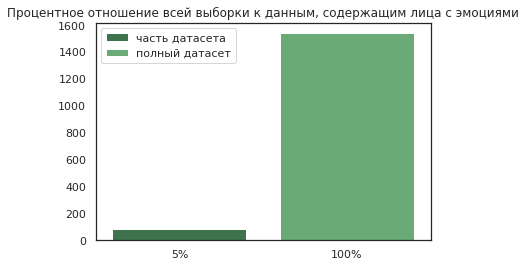

In [ ]:
sns.set(style="white")
pal = sns.color_palette("Greens_d", 2)
rank = np.array(range(2)).argsort().argsort()
sns.barplot(x = [str(round(len(df_emodji)/len(df)*100))+'%', '100%'], y = [len(df_emodji), len(df)], hue=["часть датасета","полный датасет"], dodge=False, palette=np.array(pal[::-1])[rank])
plt.title('Процентное отношение всей выборки к данным, содержащим лица с эмоциями')

In [ ]:
print('Часть выборки смайликов, которая содержит лица с эмоциями: '+ str(round(len(df_emodji)/len(df)*100))+'% это ' + str(len(df_emodji)) + ' смайлика')
print('Вся выборка: '+ ' 100% это ' + str(len(df)) + ' смайликов')

Часть выборки смайликов, которая содержит лица с эмоциями: 5% это 83 смайлика
Вся выборка:  100% это 1540 смайликов


После проверки можно удалить нужное количество смайликов уже в итоговом датасете

In [ ]:
df.drop(df.index[86:], axis=0, inplace=True)

In [ ]:
df.tail()

,emodji,desc
81,🤭,Face With Hand Over Mouth
82,🧐,Face With Monocle
83,🤓,Nerd Face
84,😈,Smiling Face With Horns
85,👿,Angry Face With Horns


Для того, чтобы разделить смайлики на категории добавляю новую колонку 'categories', по умолчанию значение 'nocode'

In [ ]:
df['categories'] = 'nocode'

In [ ]:
df.head()

,emodji,desc,categories
0,😀,Grinning Face,nocode
1,😁,Beaming Face With Smiling Eyes,nocode
2,😂,Face With Tears of Joy,nocode
3,🤣,Rolling on the Floor Laughing,nocode
4,😃,Grinning Face With Big Eyes,nocode


Исходя из концепции решения, разбиваю вручную смайлики на категории. Разбиение основывалось на субъективном и общепринятом представлении каждой эмоции

In [ ]:
df['categories'][:10] = 'happy'
df['categories'][19] = 'happy'
df['categories'][27] = 'happy'
df['categories'][40] = 'happy'
df['categories'][76] = 'happy'
df['categories'][11:17] = 'surprise'
df['categories'][20] = 'surprise'
df['categories'][30] = 'surprise'
df['categories'][47] = 'surprise'
df['categories'][64] = 'surprise'
df['categories'][28] = 'angry'
df['categories'][53] = 'angry'
df['categories'][67:70] = 'angry'
df['categories'][85] = 'angry'
df['categories'][29] = 'sad'
df['categories'][34] = 'sad'
df['categories'][42] = 'sad'
df['categories'][43] = 'sad'
df['categories'][48:53] = 'sad'
df['categories'][54:60] = 'sad'
df['categories'][41] = 'disgust'
df['categories'][73:75] = 'disgust'

In [ ]:
#проверяю разбиение
df.tail(15)

,emodji,desc,categories
71,🤒,Face With Thermometer,nocode
72,🤕,Face With Head-Bandage,nocode
73,🤢,Nauseated Face,disgust
74,🤮,Face Vomiting,disgust
75,🤧,Sneezing Face,nocode
76,😇,Smiling Face With Halo,happy
77,🤠,Cowboy Hat Face,nocode
78,🤡,Clown Face,nocode
79,🤥,Lying Face,nocode
80,🤫,Shushing Face,nocode


В итоге получилось, что некоторые смайлики не подходят под определение конкретной эмоции. Например, 'Cowboy Hat Face' нельзя отнести конкретно к одной из категорий эмоций

In [ ]:
df3 = df[df.categories == 'nocode']

In [ ]:
#удаляю все строки, содержащие 'nocode' в столбце с категорией
df = df[df.categories != 'nocode']

In [ ]:
print(f'Итоговое количество смайликов для дальнейшей подстановки {len(df)}')

Итоговое количество смайликов для дальнейшей подстановки 48


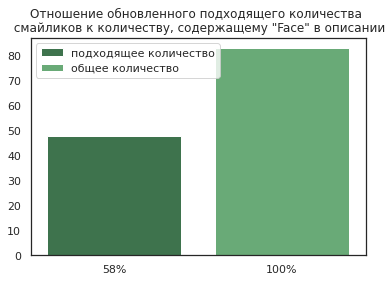

In [ ]:
pal = sns.color_palette("Greens_d", 2)
rank = np.array(range(2)).argsort().argsort()
labels=["подходящее количество","общее количество"]
sns.barplot(x = [str(round(len(df)/len(df_emodji)*100))+'%', '100%'], y = [len(df), len(df_emodji)],hue=labels, dodge=False, palette=np.array(pal[::-1])[rank])
plt.title('Отношение обновленного подходящего количества \n смайликов к количеству, содержащему "Face" в описании')
plt.legend(loc='upper left')

In [ ]:
print('Часть выборки смайликов, которая содержит подходящие лица с эмоциями: '+ str(round(len(df)/len(df_emodji)*100))+'% это ' + str(len(df)) + ' смайлика')
print('Часть выборки смайликов, которая содержит "Face" в своём описании: '+ ' 100% это ' + str(len(df_emodji)) + ' смайликов')

Часть выборки смайликов, которая содержит подходящие лица с эмоциями: 58% это 48 смайлика
Часть выборки смайликов, которая содержит "Face" в своём описании:  100% это 83 смайликов


In [ ]:
#количество смайликов в каждой из категорий
df.categories.value_counts()

sad         15
happy       14
surprise    10
angry        6
disgust      3
Name: categories, dtype: int64

В итоге, из всей выборки со смайликами, осталась только малая часть. При этом смайликов, подходящих под категорию 'sad',  больше всего (15), а смайликов, определяющих 'disgust' - меньше (всего 3)

In [ ]:
percent = []
for i in df.categories.value_counts():
  percent.append(round((100*i /sum(df.categories.value_counts())),2))

In [ ]:
percent

[31.25, 29.17, 20.83, 12.5, 6.25]

[Text(0, 0, '31.25%'),
 Text(0, 0, '29.17%'),
 Text(0, 0, '20.83%'),
 Text(0, 0, '12.5%'),
 Text(0, 0, '6.25%')]

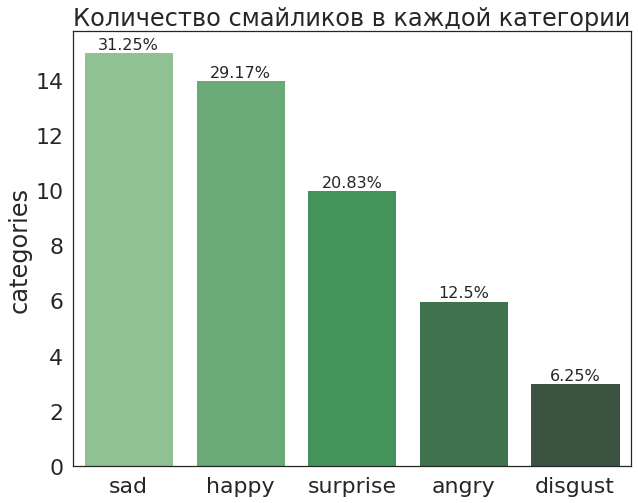

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.set(style="white", font_scale = 2)
pal = sns.color_palette("Greens_d", len(percent))
rank = np.array(percent).argsort().argsort()
ax = sns.barplot(x = ['sad', 'happy', 'surprise', 'angry', 'disgust'], y = df.categories.value_counts(), palette=np.array(pal[::-1])[rank])
ax.set_title('Количество смайликов в каждой категории')
ax.bar_label(ax.containers[0], labels=[(str(i)+'%') for i in percent], fontsize=16)

## Предобработка датасета с твитами

После датасета со смайликами, нормализацию необходимо произвести с датасетом твитов

In [ ]:
#загрузка данных
df2 = pd.read_csv("drive/MyDrive/smileannotationsfinal.csv", header=None, names=["Tweet_id", "Text", "emotions"])

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3085 entries, 0 to 3084
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Tweet_id  3085 non-null   int64 
 1   Text      3085 non-null   object
 2   emotions  3085 non-null   object
dtypes: int64(1), object(2)
memory usage: 72.4+ KB


In [ ]:
df2.head()

,Tweet_id,Text,emotions
0,611857364396965889,@aandraous @britishmuseum @AndrewsAntonio Merc...,nocode
1,614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
2,614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy
3,614877582664835073,@Sofabsports thank you for following me back. ...,happy
4,611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy


Данные об id твита не несут никакой полезной информации, поэтому столбец `'Tweet_id'` можно удалить

In [ ]:
df2.drop("Tweet_id", axis=1, inplace=True)

Можно заметить, что твиты содержат тэги, ссылки, а также другие языки (кроме английского)

In [ ]:
df2.head(15)

,Text,emotions
0,@aandraous @britishmuseum @AndrewsAntonio Merc...,nocode
1,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
2,@SelectShowcase @Tate_StIves ... Replace with ...,happy
3,@Sofabsports thank you for following me back. ...,happy
4,@britishmuseum @TudorHistory What a beautiful ...,happy
5,@NationalGallery @ThePoldarkian I have always ...,happy
6,"@britishmuseum say wot, mate?",nocode
7,Two workshops on evaluating audience engagemen...,nocode
8,"A Forest Road, by Thomas Gainsborough 1750 Oil...",nocode
9,Lucky @FitzMuseum_UK! Good luck @MirandaStearn...,happy


Пустых строк нет, общее количество датасета - 3085

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3085 entries, 0 to 3084
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      3085 non-null   object
 1   emotions  3085 non-null   object
dtypes: object(2)
memory usage: 48.3+ KB


In [ ]:
#пример твита
df2['Text'][7]

'Two workshops on evaluating audience engagement @NationalGallery + @Cambridge_Uni early July http://t.co/8X3nLQVfQg http://t.co/4pNnjGzmEP'

При выводе количествва твитов в каждой из категории видно, что больше 1500 твитов не имеют категории. Также есть категории, которые состоят из нескольких эмоций, при этом их количество слишком мало для того, что обучать на них модель

In [ ]:
#количество твитов по категориям
df2['emotions'].value_counts()

nocode               1572
happy                1137
not-relevant          214
angry                  57
surprise               35
sad                    32
happy|surprise         11
happy|sad               9
disgust|angry           7
disgust                 6
sad|disgust             2
sad|angry               2
sad|disgust|angry       1
Name: emotions, dtype: int64

Больше всего твитов, которые имеют категорию 'happy', после этого идет категория 'not-relevant', которая не имеет эмоциональную окраску и является нейтральной.

Text(0.5, 1.0, 'Категории твитов')

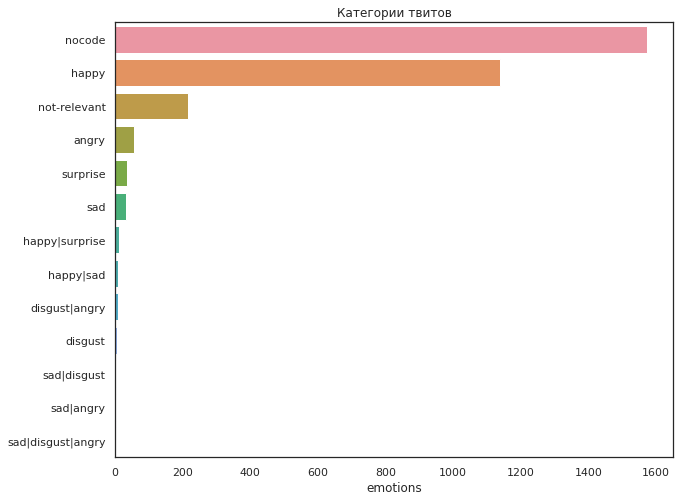

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(x = df2['emotions'].value_counts(), y =  ['nocode','happy', 'not-relevant', 'angry', 'surprise','sad','happy|surprise','happy|sad','disgust|angry', 'disgust', 'sad|disgust','sad|angry', 'sad|disgust|angry' ], orient='h')
plt.title('Категории твитов')

In [ ]:
no_code = round(len(df2[df2['emotions']=='nocode'])/len(df2['emotions'])*100)
other = round(len(df2[df2['emotions']!='nocode'])/len(df2['emotions'])*100)

Примеров с 'nocode' больше, они составляют 51%, тогда как все остальные - 49%

Text(0.5, 1.0, 'Отношение твитов категории "nocode" \n и твитов остальных категорий')

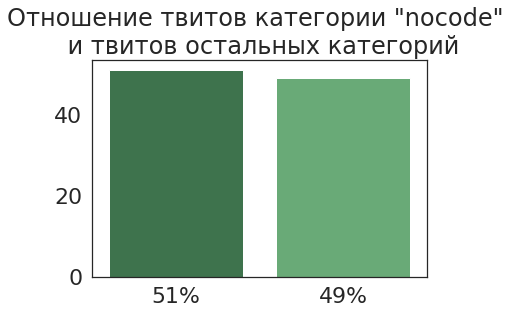

In [ ]:
sns.set(style="white", font_scale = 2)
pal = sns.color_palette("Greens_d", 2)
rank = np.array(range(2)).argsort().argsort()
sns.barplot(x = [str(no_code)+'%', str(other)+'%'], y = [no_code, other], palette=np.array(pal[::-1])[rank])
plt.title('Отношение твитов категории "nocode" \n и твитов остальных категорий')

In [ ]:
print('Примеры с "nocode" составляют ' + str(no_code) + '% это ' + str(round(len(df2[df2['emotions']=='nocode']))) + ' элементов')
print('Примеры без "nocode" составляют ' + str(other) + '% это ' + str(round(len(df2[df2['emotions']!='nocode']))) + ' элементов')

Примеры с "nocode" составляют 51% это 1572 элементов
Примеры без "nocode" составляют 49% это 1513 элементов


Исходя из этого, больше половины данных из выборки должны быть удалены

In [ ]:
df3 = df2[df2.emotions == 'nocode']

In [ ]:
#удаление твитов с категорией 'nocode'
df2 = df2[df2.emotions != 'nocode']

In [ ]:
df2['emotions'].value_counts()

happy                1137
not-relevant          214
angry                  57
surprise               35
sad                    32
happy|surprise         11
happy|sad               9
disgust|angry           7
disgust                 6
sad|disgust             2
sad|angry               2
sad|disgust|angry       1
Name: emotions, dtype: int64

Text(0.5, 1.0, 'Категории твитов без "nocode"')

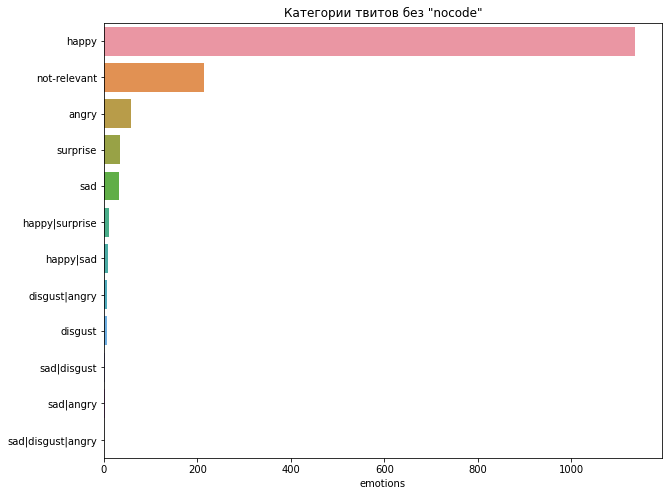

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(x = df2['emotions'].value_counts(), y =  ['happy', 'not-relevant', 'angry', 'surprise','sad','happy|surprise','happy|sad','disgust|angry', 'disgust', 'sad|disgust','sad|angry', 'sad|disgust|angry' ], orient='h')
plt.title('Категории твитов без "nocode"')

**Нормализация**

Чтобы не изменять исходные данные, создается новый столбец 'TextAfterEdit'. С помощью рекурсивных выражений происходит нормализация твитов

In [ ]:
#удаление всех упоминаний в твитах (@nickname)
df3['TextAfterEdit'] = [re.sub(r"@[\w'._+-]+", '', i, flags=re.IGNORECASE) for i in df3['Text']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#удаление всех упоминаний в твитах (@nickname)
df2['TextAfterEdit'] = [re.sub(r"@[\w'._+-]+", '', i, flags=re.IGNORECASE) for i in df2['Text']]

In [ ]:
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)

In [ ]:
#исходные твиты и измененные
text = df2[['Text','TextAfterEdit']]
text.head(8)

,Text,TextAfterEdit
1,Dorian Gray with Rainbow Scarf #LoveWins (from @britishmuseum http://t.co/Q4XSwL0esu) http://t.co/h0evbTBWRq,Dorian Gray with Rainbow Scarf #LoveWins (from http://t.co/Q4XSwL0esu) http://t.co/h0evbTBWRq
2,@SelectShowcase @Tate_StIves ... Replace with your wish which the artist uses in next installation! It was entralling!,... Replace with your wish which the artist uses in next installation! It was entralling!
3,@Sofabsports thank you for following me back. Great to hear from a diverse &amp; interesting panel #DefeatingDepress...,thank you for following me back. Great to hear from a diverse &amp; interesting panel #DefeatingDepression
4,@britishmuseum @TudorHistory What a beautiful jewel / portrait. Is the 'R' for Rex ?,What a beautiful jewel / portrait. Is the 'R' for Rex ?
5,@NationalGallery @ThePoldarkian I have always loved this painting.,I have always loved this painting.
9,Lucky @FitzMuseum_UK! Good luck @MirandaStearn &amp; see you soon :) @fitalbott @JoReilly00,Lucky ! Good luck &amp; see you soon :)
12,Yr 9 art students are off to the @britishmuseum today. Enjoy!,Yr 9 art students are off to the today. Enjoy!
15,@RAMMuseum Please vote for us as @sainsbury #sidwell's local charity PRT http://t.co/IguyWk5MJT http://t.co/5kPGLNeW4H,Please vote for us as #sidwell's local charity PRT http://t.co/IguyWk5MJT http://t.co/5kPGLNeW4H


In [ ]:
#удаление хэштегов
df3['TextAfterEdit'] = [re.sub(r"#[\w'._+-]+", '', i, flags=re.IGNORECASE) for i in df3['TextAfterEdit']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#удаление хэштегов
df2['TextAfterEdit'] = [re.sub(r"#[\w'._+-]+", '', i, flags=re.IGNORECASE) for i in df2['TextAfterEdit']]

In [ ]:
text = df3[['Text','TextAfterEdit']]
text.head(8)

,Text,TextAfterEdit
0,@aandraous @britishmuseum @AndrewsAntonio Merc...,Merci pour le partage!
6,"@britishmuseum say wot, mate?","say wot, mate?"
7,Two workshops on evaluating audience engagemen...,Two workshops on evaluating audience engagemen...
8,"A Forest Road, by Thomas Gainsborough 1750 Oil...","A Forest Road, by Thomas Gainsborough 1750 Oil..."
10,"""1...2..."" ""non arrête mon brush!"". l.Alma|A f...","""1...2..."" ""non arrête mon brush!"". l.Alma|A f..."
11,The two works in our free #DuccioCaro exhibiti...,The two works in our free exhibition play wit...
13,@NationalGallery Indeed,Indeed
14,“@britishmuseum: More #Waterloo200? Live #Peri...,“: More ? Live tonight with Dan Snow in htt...


In [ ]:
text = df2[['Text','TextAfterEdit']]
text.head(8)

,Text,TextAfterEdit
1,Dorian Gray with Rainbow Scarf #LoveWins (from @britishmuseum http://t.co/Q4XSwL0esu) http://t.co/h0evbTBWRq,Dorian Gray with Rainbow Scarf (from http://t.co/Q4XSwL0esu) http://t.co/h0evbTBWRq
2,@SelectShowcase @Tate_StIves ... Replace with your wish which the artist uses in next installation! It was entralling!,... Replace with your wish which the artist uses in next installation! It was entralling!
3,@Sofabsports thank you for following me back. Great to hear from a diverse &amp; interesting panel #DefeatingDepress...,thank you for following me back. Great to hear from a diverse &amp; interesting panel
4,@britishmuseum @TudorHistory What a beautiful jewel / portrait. Is the 'R' for Rex ?,What a beautiful jewel / portrait. Is the 'R' for Rex ?
5,@NationalGallery @ThePoldarkian I have always loved this painting.,I have always loved this painting.
9,Lucky @FitzMuseum_UK! Good luck @MirandaStearn &amp; see you soon :) @fitalbott @JoReilly00,Lucky ! Good luck &amp; see you soon :)
12,Yr 9 art students are off to the @britishmuseum today. Enjoy!,Yr 9 art students are off to the today. Enjoy!
15,@RAMMuseum Please vote for us as @sainsbury #sidwell's local charity PRT http://t.co/IguyWk5MJT http://t.co/5kPGLNeW4H,Please vote for us as local charity PRT http://t.co/IguyWk5MJT http://t.co/5kPGLNeW4H


In [ ]:
#удаление ссылок
df3['TextAfterEdit'] = [re.sub(r"https?://[^,\s]+,?", '', i, flags=re.IGNORECASE) for i in df3['TextAfterEdit']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#удаление ссылок
df2['TextAfterEdit'] = [re.sub(r"https?://[^,\s]+,?", '', i, flags=re.IGNORECASE) for i in df2['TextAfterEdit']]

In [ ]:
text = df2[['Text','TextAfterEdit']]
text.head(8)

,Text,TextAfterEdit
1,Dorian Gray with Rainbow Scarf #LoveWins (from @britishmuseum http://t.co/Q4XSwL0esu) http://t.co/h0evbTBWRq,Dorian Gray with Rainbow Scarf (from
2,@SelectShowcase @Tate_StIves ... Replace with your wish which the artist uses in next installation! It was entralling!,... Replace with your wish which the artist uses in next installation! It was entralling!
3,@Sofabsports thank you for following me back. Great to hear from a diverse &amp; interesting panel #DefeatingDepress...,thank you for following me back. Great to hear from a diverse &amp; interesting panel
4,@britishmuseum @TudorHistory What a beautiful jewel / portrait. Is the 'R' for Rex ?,What a beautiful jewel / portrait. Is the 'R' for Rex ?
5,@NationalGallery @ThePoldarkian I have always loved this painting.,I have always loved this painting.
9,Lucky @FitzMuseum_UK! Good luck @MirandaStearn &amp; see you soon :) @fitalbott @JoReilly00,Lucky ! Good luck &amp; see you soon :)
12,Yr 9 art students are off to the @britishmuseum today. Enjoy!,Yr 9 art students are off to the today. Enjoy!
15,@RAMMuseum Please vote for us as @sainsbury #sidwell's local charity PRT http://t.co/IguyWk5MJT http://t.co/5kPGLNeW4H,Please vote for us as local charity PRT


In [ ]:
#удаление знаков препинания
df3['TextAfterEdit'] = df3['TextAfterEdit'].str.replace('[^\w\s]','')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#удаление знаков препинания
df2['TextAfterEdit'] = df2['TextAfterEdit'].str.replace('[^\w\s]','')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
text = df3[['Text','TextAfterEdit']]
text.head(8)

,Text,TextAfterEdit
0,@aandraous @britishmuseum @AndrewsAntonio Merc...,Merci pour le partage
6,"@britishmuseum say wot, mate?",say wot mate
7,Two workshops on evaluating audience engagemen...,Two workshops on evaluating audience engagemen...
8,"A Forest Road, by Thomas Gainsborough 1750 Oil...",A Forest Road by Thomas Gainsborough 1750 Oil ...
10,"""1...2..."" ""non arrête mon brush!"". l.Alma|A f...",12 non arrête mon brush lAlmaA favourite custo...
11,The two works in our free #DuccioCaro exhibiti...,The two works in our free exhibition play wit...
13,@NationalGallery Indeed,Indeed
14,“@britishmuseum: More #Waterloo200? Live #Peri...,More Live tonight with Dan Snow in


In [ ]:
text = df2[['Text','TextAfterEdit']]
text.head(8)

,Text,TextAfterEdit
1,Dorian Gray with Rainbow Scarf #LoveWins (from @britishmuseum http://t.co/Q4XSwL0esu) http://t.co/h0evbTBWRq,Dorian Gray with Rainbow Scarf from
2,@SelectShowcase @Tate_StIves ... Replace with your wish which the artist uses in next installation! It was entralling!,Replace with your wish which the artist uses in next installation It was entralling
3,@Sofabsports thank you for following me back. Great to hear from a diverse &amp; interesting panel #DefeatingDepress...,thank you for following me back Great to hear from a diverse amp interesting panel
4,@britishmuseum @TudorHistory What a beautiful jewel / portrait. Is the 'R' for Rex ?,What a beautiful jewel portrait Is the R for Rex
5,@NationalGallery @ThePoldarkian I have always loved this painting.,I have always loved this painting
9,Lucky @FitzMuseum_UK! Good luck @MirandaStearn &amp; see you soon :) @fitalbott @JoReilly00,Lucky Good luck amp see you soon
12,Yr 9 art students are off to the @britishmuseum today. Enjoy!,Yr 9 art students are off to the today Enjoy
15,@RAMMuseum Please vote for us as @sainsbury #sidwell's local charity PRT http://t.co/IguyWk5MJT http://t.co/5kPGLNeW4H,Please vote for us as local charity PRT


In [ ]:
#удаление чисел
df3['TextAfterEdit'] = [re.sub(r'[^\w\s]+|[\d]+', '', i, flags=re.IGNORECASE) for i in df3['TextAfterEdit']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#удаление чисел
df2['TextAfterEdit'] = [re.sub(r'[^\w\s]+|[\d]+', '', i, flags=re.IGNORECASE) for i in df2['TextAfterEdit']]

In [ ]:
RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)

In [ ]:
#удаление лишних пробелов (больше одного пробела подряд)
df3['TextAfterEdit'] = [re.sub(RE_WSPACE, ' ', i) for i in df3['TextAfterEdit']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#удаление лишних пробелов (больше одного пробела подряд)
df2['TextAfterEdit'] = [re.sub(RE_WSPACE, ' ', i) for i in df2['TextAfterEdit']]

In [ ]:
text = df3[['Text','TextAfterEdit']]
text.head(8)

,Text,TextAfterEdit
0,@aandraous @britishmuseum @AndrewsAntonio Merc...,Merci pour le partage
6,"@britishmuseum say wot, mate?",say wot mate
7,Two workshops on evaluating audience engagemen...,Two workshops on evaluating audience engagemen...
8,"A Forest Road, by Thomas Gainsborough 1750 Oil...",A Forest Road by Thomas Gainsborough Oil on Ca...
10,"""1...2..."" ""non arrête mon brush!"". l.Alma|A f...",non arrête mon brush lAlmaA favourite custom
11,The two works in our free #DuccioCaro exhibiti...,The two works in our free exhibition play with...
13,@NationalGallery Indeed,Indeed
14,“@britishmuseum: More #Waterloo200? Live #Peri...,More Live tonight with Dan Snow in


In [ ]:
text = df2[['Text','TextAfterEdit']]
text.head(8)

,Text,TextAfterEdit
1,Dorian Gray with Rainbow Scarf #LoveWins (from @britishmuseum http://t.co/Q4XSwL0esu) http://t.co/h0evbTBWRq,Dorian Gray with Rainbow Scarf from
2,@SelectShowcase @Tate_StIves ... Replace with your wish which the artist uses in next installation! It was entralling!,Replace with your wish which the artist uses in next installation It was entralling
3,@Sofabsports thank you for following me back. Great to hear from a diverse &amp; interesting panel #DefeatingDepress...,thank you for following me back Great to hear from a diverse amp interesting panel
4,@britishmuseum @TudorHistory What a beautiful jewel / portrait. Is the 'R' for Rex ?,What a beautiful jewel portrait Is the R for Rex
5,@NationalGallery @ThePoldarkian I have always loved this painting.,I have always loved this painting
9,Lucky @FitzMuseum_UK! Good luck @MirandaStearn &amp; see you soon :) @fitalbott @JoReilly00,Lucky Good luck amp see you soon
12,Yr 9 art students are off to the @britishmuseum today. Enjoy!,Yr art students are off to the today Enjoy
15,@RAMMuseum Please vote for us as @sainsbury #sidwell's local charity PRT http://t.co/IguyWk5MJT http://t.co/5kPGLNeW4H,Please vote for us as local charity PRT


Ранее было выявлено наличие другого языка в твитах. Поэтому проверяю на наличие французского, немецкого, японского, китайского, корейского, арабского, итальянского и испанского языков

In [ ]:
#инициализация необходимых языков
languages = [Language.ENGLISH, Language.FRENCH, Language.GERMAN, Language.JAPANESE, Language.CHINESE, Language.KOREAN, Language.ARABIC, Language.ITALIAN, Language.SPANISH]

In [ ]:
detector = LanguageDetectorBuilder.from_languages(*languages).build()

Разбиение на массивы. Твиты на английском языке в один массив, а на других - в другой

In [ ]:
arr_eng, arr_other = [], []
for i in df3['TextAfterEdit']:
  if detector.detect_language_of(i) == Language.ENGLISH:
    arr_eng.append(i)
  else:
    arr_other.append(i)

In [ ]:
arr_eng, arr_other = [], []
for i in df2['TextAfterEdit']:
  if detector.detect_language_of(i) == Language.ENGLISH:
    arr_eng.append(i)
  else:
    arr_other.append(i)

In [ ]:
#количество твитов на английском языке
eng = round((len(arr_eng)/len(df2['TextAfterEdit']))*100, 2)

In [ ]:
#количество твитов на других языках
other = round((len(arr_other)/len(df2['TextAfterEdit']))*100, 2)

In [ ]:
print('На английском языке: ' + str(eng) + '% это ' + str(len(arr_eng)) + ' твита')
print('На других языках: ' + str(other) + '% это ' + str(len(arr_other)) + ' твита')

На английском языке: 93.99% это 1422 твита
На других языках: 6.01% это 91 твита


Твиты на других языках имеют маленький процент, поэтому их легче удалить, т.к. на таком количестве модель плохо будет плохо обучаться, считая эти данные за некие выбросы

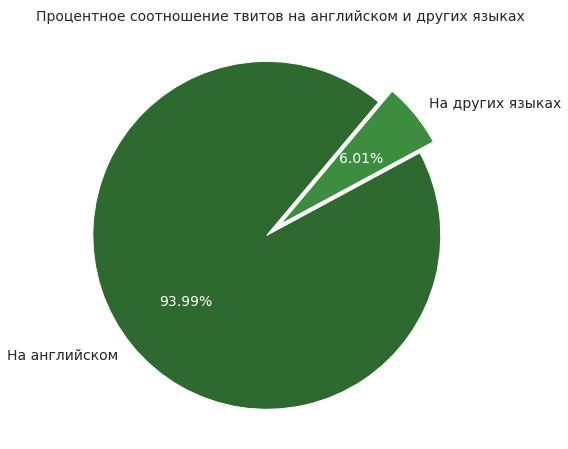

In [ ]:
sns.set()
fig1, ax1 = plt.subplots(figsize=(10,8))
myexplode = [0.1, 0]
colors = ['#2e6930','#3d8c40']
textprops = {"fontsize":14}
_, _, autotexts = ax1.pie([len(arr_eng), len(arr_other)],
                          labels=['На английском', 'На других языках'],
                          startangle=50, autopct='%1.2f%%',
                          explode = myexplode,
                          colors = colors,
                          textprops = textprops)
ax1.set_title('Процентное соотношение твитов на английском и других языках',
              fontsize=14,
              y=1.0,
              pad=-14)
for autotext in autotexts:
    autotext.set_color('white')


In [ ]:
#удаление твитов, которые имеют другой язык
df3 = df3[~df3.TextAfterEdit.isin(arr_other)]

In [ ]:
#удаление твитов, которые имеют другой язык
df2 = df2[~df2.TextAfterEdit.isin(arr_other)]

In [ ]:
df2.head()

,Text,emotions,TextAfterEdit
1,Dorian Gray with Rainbow Scarf #LoveWins (from @britishmuseum http://t.co/Q4XSwL0esu) http://t.co/h0evbTBWRq,happy,Dorian Gray with Rainbow Scarf from
2,@SelectShowcase @Tate_StIves ... Replace with your wish which the artist uses in next installation! It was entralling!,happy,Replace with your wish which the artist uses in next installation It was entralling
3,@Sofabsports thank you for following me back. Great to hear from a diverse &amp; interesting panel #DefeatingDepress...,happy,thank you for following me back Great to hear from a diverse amp interesting panel
4,@britishmuseum @TudorHistory What a beautiful jewel / portrait. Is the 'R' for Rex ?,happy,What a beautiful jewel portrait Is the R for Rex
5,@NationalGallery @ThePoldarkian I have always loved this painting.,happy,I have always loved this painting


**Лемматизация и стемминг**

Перед тем, как провести лемматизацию и стемминг необходимо токенизировать твиты

In [ ]:
#токенизация
df2['Text_token'] = df2['TextAfterEdit'].apply(word_tokenize)

In [ ]:
wordnet_lem = WordNetLemmatizer()

In [ ]:
#лемматизация
Lemm_arr = []
#из токенизированного твита каждое слово приводится к определенной лемме
for i, plurals in enumerate(df2['Text_token']):
  singles = [wordnet_lem.lemmatize(plural) for plural in plurals]
  Lemm_arr.append(singles)

In [ ]:
#сохранение в отдельную колонку
df2['Text_lemm'] = Lemm_arr

In [ ]:
#сравнение текста обработанных регулярными выражениями твитов с лемматизированными
text = df2[['TextAfterEdit','Text_lemm']]
text.head(8)

,TextAfterEdit,Text_lemm
1,Dorian Gray with Rainbow Scarf from,"[Dorian, Gray, with, Rainbow, Scarf, from]"
2,Replace with your wish which the artist uses ...,"[Replace, with, your, wish, which, the, artist..."
3,thank you for following me back Great to hear...,"[thank, you, for, following, me, back, Great, ..."
4,What a beautiful jewel portrait Is the R for ...,"[What, a, beautiful, jewel, portrait, Is, the,..."
5,I have always loved this painting,"[I, have, always, loved, this, painting]"
9,Lucky Good luck amp see you soon,"[Lucky, Good, luck, amp, see, you, soon]"
12,Yr art students are off to the today Enjoy,"[Yr, art, student, are, off, to, the, today, E..."
15,Please vote for us as local charity PRT,"[Please, vote, for, u, a, local, charity, PRT]"


Во время стеминга также происходит приведение к нижнему регистру

In [ ]:
stemmer = PorterStemmer()

In [ ]:
#стемминг
Stemmer_arr = []
for i, plurals in enumerate(df2['Text_lemm']):
  singles = [stemmer.stem(plural) for plural in plurals]
  Stemmer_arr.append(singles)

In [ ]:
df2['Text_stemm'] = Stemmer_arr

In [ ]:
#сравнение твитов до и после стемминга
text = df2[['TextAfterEdit','Text_stemm']]
text.head(8)

,TextAfterEdit,Text_stemm
1,Dorian Gray with Rainbow Scarf from,"[dorian, gray, with, rainbow, scarf, from]"
2,Replace with your wish which the artist uses ...,"[replac, with, your, wish, which, the, artist,..."
3,thank you for following me back Great to hear...,"[thank, you, for, follow, me, back, great, to,..."
4,What a beautiful jewel portrait Is the R for ...,"[what, a, beauti, jewel, portrait, is, the, r,..."
5,I have always loved this painting,"[i, have, alway, love, thi, paint]"
9,Lucky Good luck amp see you soon,"[lucki, good, luck, amp, see, you, soon]"
12,Yr art students are off to the today Enjoy,"[yr, art, student, are, off, to, the, today, e..."
15,Please vote for us as local charity PRT,"[pleas, vote, for, u, a, local, chariti, prt]"


**Удаление стоп-слов**

In [ ]:
#инициализация словаря для английских слов
english_stopwords = stopwords.words("english")

Было выявлено, что есть твиты, которые содержат только слова 'I do I do I do', т.е. состоят только из стоп-слов. Если их удалить, то строки окажутся пустыми и их придется удалять, однако данных мало для обучения, поэтому данные слова не будут внесены в стоп-слова

In [ ]:
not_stopwords = {'i', 'do'}

In [ ]:
final_stop_words = set([word for word in english_stopwords if word not in not_stopwords])

In [ ]:
#удаление стоп-слов
df_stop = df2.Text_stemm.apply(lambda x: [item for item in x if item not in final_stop_words])
df_stop.head(20)

1                        [dorian, gray, rainbow, scarf]
2     [replac, wish, artist, us, next, instal, wa, e...
3     [thank, follow, back, great, hear, divers, amp...
4                     [beauti, jewel, portrait, r, rex]
5                          [i, alway, love, thi, paint]
9                   [lucki, good, luck, amp, see, soon]
12                     [yr, art, student, today, enjoy]
15                [pleas, vote, u, local, chariti, prt]
16                     [got, plan, privatis, ani, role]
18                                             [beauti]
20                                     [awesom, museum]
21             [whi, do, pay, brilliant, staff, poorli]
26                                        [soo, beauti]
28            [one, favourit, paint, wa, great, artist]
30    [magna, carta, exhibit, wa, quit, extraordinar...
31               [peopl, sign, worth, dont, miss, book]
33                       [kudo, topflight, wc, exhibit]
36                           [ooh, pleas, let, u

In [ ]:
df2['Text_stop'] = df_stop

In [ ]:
#сравнение твитов
text = df2[['TextAfterEdit','Text_stop']]
text.head(8)

,TextAfterEdit,Text_stop
1,Dorian Gray with Rainbow Scarf from,"[dorian, gray, rainbow, scarf]"
2,Replace with your wish which the artist uses ...,"[replac, wish, artist, us, next, instal, wa, e..."
3,thank you for following me back Great to hear...,"[thank, follow, back, great, hear, divers, amp..."
4,What a beautiful jewel portrait Is the R for ...,"[beauti, jewel, portrait, r, rex]"
5,I have always loved this painting,"[i, alway, love, thi, paint]"
9,Lucky Good luck amp see you soon,"[lucki, good, luck, amp, see, soon]"
12,Yr art students are off to the today Enjoy,"[yr, art, student, today, enjoy]"
15,Please vote for us as local charity PRT,"[pleas, vote, u, local, chariti, prt]"


In [ ]:
#провека на наличие пустых строк
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1513 entries, 1 to 3083
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Text           1513 non-null   object
 1   emotions       1513 non-null   object
 2   TextAfterEdit  1513 non-null   object
dtypes: object(3)
memory usage: 47.3+ KB


In [ ]:
#обновление индексов
df2 = df2.reset_index(drop=True)

## Преобразование стобца "emotions"

В выборке есть один элемент, содержащий три эмоции, что не позволит обучить модель для данной категории. Также две категории имеют всего по два примера, что тоже не позволит корректно обучить модель. Там, где несколько эмоций, примеров недостаточно, чтобы обучить на них модель.

Гипотеза: можно объединить данные категории в подобные, чтобы было больше примеров. Также можно просто удалить данные категории, что будет объективнее, так как я не буду нарушать целостность других категории и ложно не обучать модель

Помимо этого, категории эмоций необходимо преобразовать в числовой формат. В зависимости от моделей будет использован разный метод преобразования (label encoding, one-hot encoding). Так, для обычных моделей машинного обучения категории преобразовываются с помощью label encoding

In [ ]:
df2 = df2[~df2.emotions.str.contains('\|')]

In [ ]:
#список уникальных значений и соответствующее им количество твитов
df2['emotions'].value_counts()

happy           1099
not-relevant     163
angry             56
surprise          34
sad               32
disgust            6
Name: emotions, dtype: int64

Для того, чтобы понять, нужно ли оставлять категории с несколькими эмоциями, выведу круговую диаграмму с процентным соотношением каждой категории. Таким образом, категории с несколькими эмоциями для увеличения выборки лучше разделить по категориям с одиночными эмоциями

In [ ]:
labels = df2.emotions.unique()
percentage = []
for i in df2.emotions.value_counts():
  percentage.append(round((100*i /sum(df2.emotions.value_counts())),2))

In [ ]:
arr_percent_labels = []
for i, j in zip(labels, percentage):
  arr_percent_labels.append(str(i) + ' (' + str(j) + '%)')
arr_percent_labels

['happy (77.29%)',
 'not-relevant (11.46%)',
 'angry (3.94%)',
 'disgust|angry (2.39%)',
 'disgust (2.25%)',
 'happy|surprise (0.77%)',
 'sad (0.63%)',
 'happy|sad (0.49%)',
 'surprise (0.42%)',
 'sad|disgust (0.14%)',
 'sad|angry (0.14%)',
 'sad|disgust|angry (0.07%)']

Text(0.5, 1.0, 'Процентное соотношение категорий эмоций')

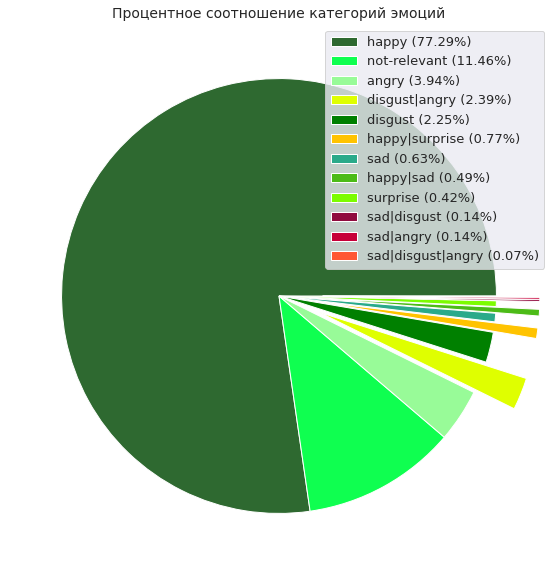

In [ ]:
fig1, ax1 = plt.subplots(figsize=(15, 10))
myexplode = [0, 0, 0, 0.2, 0, 0.2, 0, 0.2, 0, 0.2, 0.2, 0.2]
colors = ['#2e6930','#0FFF50', '#98FB98','#DFFF00','#008000', '#FFC300', '#2AAA8A', '#4CBB17', '#7CFC00', '#900C3F', '#C70039','#FF5733']
ax1.pie(df2['emotions'].value_counts(), explode = myexplode, colors = colors)
ax1.legend(loc = 'best', labels = arr_percent_labels, fontsize=13)
plt.title('Процентное соотношение категорий эмоций', fontsize=14)

Приведение категорий с несколькими эмоциями к категориям с одной эмоцией

In [ ]:
#sad|disgust|angry
df2['emotions'][1386] = 'angry'
#sad|angry
df2['emotions'][451] = 'angry'
df2['emotions'][1198] = 'angry'
#sad|disgust
df2['emotions'][287] = 'disgust'
df2['emotions'][968] = 'sad'
#disgust|angry
df2['emotions'][56] = 'disgust'
df2['emotions'][60] = 'angry'
df2['emotions'][133] = 'disgust'
df2['emotions'][153] = 'disgust'
df2['emotions'][628] = 'disgust'
df2['emotions'][1144] = 'disgust'
df2['emotions'][1238] = 'disgust'
#happy|sad
df2['emotions'][123] = 'sad'
df2['emotions'][388] = 'happy'
df2['emotions'][584] = 'happy'
df2['emotions'][585] = 'happy'
df2['emotions'][637] = 'happy'
df2['emotions'][934] = 'sad'
df2['emotions'][1101] = 'happy'
df2['emotions'][1213] = 'sad'
df2['emotions'][1380] = 'sad'
#happy|surprise
df2['emotions'][91] = 'surprise'
df2['emotions'][112] = 'surprise'
df2['emotions'][178] = 'happy'
df2['emotions'][354] = 'happy'
df2['emotions'][435] = 'surprise'
df2['emotions'][480] = 'surprise'
df2['emotions'][540] = 'happy'
df2['emotions'][541] = 'happy'
df2['emotions'][738] = 'surprise'
df2['emotions'][917] = 'surprise'
df2['emotions'][1282] = 'surprise'

In [ ]:
#итоговые категории
df2['emotions'].value_counts()

happy           1108
not-relevant     163
angry             60
surprise          41
sad               37
disgust           13
Name: emotions, dtype: int64

Для обычных моделей машинного обучения применялся подход label encoding, т.к. в конечном результате важна получаемая вероятность каждой из эмоций, а не значение

In [ ]:
#список уникальных значений
possible_labels = df2.emotions.unique()

In [ ]:
#присвоение каждому уникальному значению индекса
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [ ]:
print(f'Список уникальных значений и присвоенные им числа по значению индекса')
label_dict

Список уникальных значений и присвоенные им числа по значению индекса


{'happy': 0,
 'not-relevant': 1,
 'angry': 2,
 'disgust': 3,
 'sad': 4,
 'surprise': 5}

In [ ]:
#присвоение каждой категории числа из словаря
df2.emotions = df2['emotions'].map(label_dict)

In [ ]:
#измененные категории
df2['emotions'].value_counts()

0    1099
1     163
2      56
5      34
4      32
3       6
Name: emotions, dtype: int64

# **Построение моделей**

В данном разделе будет происходить построение, обучение и сравнение разных моделей.

Так, было рассмотрено два разных вида векторизации: обычная и TF-IDF с обычными моделями машинного обучения (Naive Bayes, Logistic Regression, SVM, адаптивный и градиентный бустинги). Рекуррентная модель LSTM с разными видами слоев embedding (собственный, word2vec, GloVe). Также трансформер Bert.

## Обычная векторизация


Размер словаря установлен случайным значением. Так как данных значительно меньше, то в дальнейшем он будет изменен

In [ ]:
vocab_size = 10000 #размер словаря

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, char_level=True)#объявление класса токенизатора после обработки
tokenizer.fit_on_texts(df2['Text_stop'])#создание словаря на основе отзывов выборки

In [ ]:
df_vect = df2

In [ ]:
#перевод токенизированных слов в массив цифр
df_vect['Tokens'] = tokenizer.texts_to_sequences(np.array(df_vect['Text_stop']))

In [ ]:
#перевод токенизированных слов в массив цифр
df_vect['Tokens_without_edit'] = tokenizer.texts_to_sequences(np.array(df_vect['Text']))

In [ ]:
#перемешивание датасета
df_vect = df_vect.sample(frac=1).reset_index(drop=True)

In [ ]:
df_vect.head()

,Text,emotions,TextAfterEdit,Text_token,Text_lemm,Text_stemm,Text_stop,Tokens,Tokens_without_edit
0,Good to see @liveatlica's art collection @Leed...,0,Good to see art collection Thx to et al,"[Good, to, see, art, collection, Thx, to, et, al]","[Good, to, see, art, collection, Thx, to, et, al]","[good, to, see, art, collect, thx, to, et, al]","[good, see, art, collect, thx, et, al]","[29, 9, 14, 88, 1093, 2670, 883]","[566, 566, 2578, 1, 201, 566, 2578, 1, 302, 39..."
1,@nationalgallery #AskTheGallery When will you ...,2,When will you be reinstating Candy Udwin Why ...,"[When, will, you, be, reinstating, Candy, Udwi...","[When, will, you, be, reinstating, Candy, Udwi...","[when, will, you, be, reinstat, candi, udwin, ...","[reinstat, candi, udwin, whi, art, subject, pr...","[280, 243, 534, 133, 14, 420, 338, 735]","[1399, 1, 1399, 2578, 2578, 2578, 566, 399, 25..."
2,Great &amp; Exciting news for @Tate_StIves We ...,0,Great amp Exciting news for We look forward to...,"[Great, amp, Exciting, news, for, We, look, fo...","[Great, amp, Exciting, news, for, We, look, fo...","[great, amp, excit, news, for, we, look, forwa...","[great, amp, excit, news, look, forward, next,...","[6, 5, 49, 261, 8, 21, 57, 12]","[399, 566, 1635, 566, 242, 302, 1, 1, 1399, 13..."
3,@NationalGallery Thank you for the information...,0,Thank you for the information its a very beau...,"[Thank, you, for, the, information, its, a, ve...","[Thank, you, for, the, information, it, a, ver...","[thank, you, for, the, inform, it, a, veri, be...","[thank, inform, veri, beauti, paint]","[2, 317, 23, 13, 39]","[1399, 1, 1399, 2578, 2578, 2578, 566, 399, 23..."
4,So happy that my work has been selected to exh...,0,So happy that my work has been selected to exh...,"[So, happy, that, my, work, has, been, selecte...","[So, happy, that, my, work, ha, been, selected...","[so, happi, that, my, work, ha, been, select, ...","[happi, work, ha, select, exhibit]","[73, 19, 20, 255, 4]","[2321, 1635, 1635, 2321, 199, 399, 2532, 2321,..."


In [ ]:
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)

In [ ]:
text = df_vect[['TextAfterEdit','Text_stop','Tokens']]
text.head(8)

,TextAfterEdit,Text_stop,Tokens
0,Good to see art collection Thx to et al,"[good, see, art, collect, thx, et, al]","[29, 9, 14, 88, 1093, 2670, 883]"
1,When will you be reinstating Candy Udwin Why should the arts be subject to private profit,"[reinstat, candi, udwin, whi, art, subject, privat, profit]","[280, 243, 534, 133, 14, 420, 338, 735]"
2,Great amp Exciting news for We look forward to our next visit,"[great, amp, excit, news, look, forward, next, visit]","[6, 5, 49, 261, 8, 21, 57, 12]"
3,Thank you for the information its a very beautiful painting,"[thank, inform, veri, beauti, paint]","[2, 317, 23, 13, 39]"
4,So happy that my work has been selected to exhibit for the,"[happi, work, ha, select, exhibit]","[73, 19, 20, 255, 4]"
5,Were really excited about the Jackson Pollock exhibition at the end of the month,"[realli, excit, jackson, pollock, exhibit, end, month]","[38, 49, 56, 31, 4, 156, 380]"
6,yes a day is not enough what is I have not heard of this,"[ye, day, enough, i, heard, thi]","[85, 10, 664, 1, 447, 3]"
7,Nice Love that Im touring the museum with you while I eat lunch here in Canada,"[nice, love, im, tour, museum, i, eat, lunch, canada]","[115, 7, 55, 141, 16, 1, 1095, 211, 1087]"


Было выявлено, что обучающая и тестовая выборки должны быть в соотношении 70 на 30. Если данных для теста меньше, то результаты у обычных моделей хуже. Использовались соотношения 85 на 15, 80 на 20, 75 на 25.

In [ ]:
#разделение датасета на обучающую и тестовую выборки
X_train, X_val, y_train, y_val = train_test_split(df_vect.Tokens.values, df_vect.emotions.values, test_size = 0.3, random_state=17, stratify = df_vect.emotions.values)

In [ ]:
print(f'Размер обучающей выборки: {len(X_train)}')
print(f'Размер тестовой выборки: {len(X_val)}')

Размер обучающей выборки: 995
Размер тестовой выборки: 427


In [ ]:
allreviews = np.concatenate((X_train, X_val), axis=0)

In [ ]:
#смотрим максимальную и минимальную длину твитов, а также среднее
print("Максимальная длина твита: {}".format(len(max((allreviews), key=len))))
print("Минимальная длина твита:  {}".format(len(min((allreviews), key=len))))
result = [len(x) for x in allreviews]
print("Средняя длина твита:      {}".format(np.mean(result)))

Максимальная длина твита: 17
Минимальная длина твита:  0
Средняя длина твита:      7.080872011251758


In [ ]:
#определяю усредненную длину твита
review_length = 8

In [ ]:
#приведение каждого отзыва к выбранной длине
x_train_lstm = sequence.pad_sequences(X_train, maxlen = review_length,padding='post')
x_val_lstm = sequence.pad_sequences(X_val, maxlen = review_length,padding='post')

### Модели

Для дальнейшего сравнения моделей, вычислялось время обучения для каждой модели, accuracy для обучающей и тестовой выборки. Также все данные predict записывались в файл, чтобы было легче с ними работать в дальнейшем

In [ ]:
predict = pd.DataFrame()
train_predict = pd.DataFrame()

In [ ]:
#строки для загрузки данных из файла, в котором ранее сохранялись предсказанные значения
# predict = pd.read_csv("/content/predict_ML.csv")
# train_predict = pd.read_csv("/content/train_predict_ML.csv")

In [ ]:
# predict.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
# train_predict.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

#### Naive Bayes

In [ ]:
#инициализация модели
nb = GaussianNB()

start_time = datetime.now()
#обучение модели
result_bayes = nb.fit(x_train_lstm, y_train)
end_time = datetime.now()
#нахождение времени обучения
training_time_NB = (end_time - start_time).total_seconds()

In [ ]:
predicted_train_NB = nb.predict(x_train_lstm)
accuracy_train_NB = accuracy_score(y_train, predicted_train_NB)
print('Accuracy Training data: {:.1%}'.format(accuracy_train_NB))

predicted_val_NB = nb.predict(x_val_lstm)
accuracy_val_NB = accuracy_score(y_val, predicted_val_NB)
print('Accuracy Test data: {:.1%}'.format(accuracy_val_NB))

print('Время обучения: {:.1f}s'.format(training_time_NB))

Accuracy Training data: 71.1%
Accuracy Test data: 68.1%
Время обучения: 0.0s


In [ ]:
#сохранение в файл
predict['val_naive_bayes'] = nb.predict(x_val_lstm)
train_predict['train_naive_bayes'] = nb.predict(x_train_lstm)
predict.to_csv('predict_ML.csv')
train_predict.to_csv('train_predict_ML.csv')

In [ ]:
#если уже есть загруженные предсказанные значения из файла
# predicted_train_NB = train_predict['train_naive_bayes']
# predicted_val_NB = predict['val_naive_bayes']
# accuracy_train_NB = accuracy_score(y_train, predicted_train_NB)
# accuracy_val_NB = accuracy_score(y_val, predicted_val_NB)

#### Logistic Regression

In [ ]:
#инициализация модели
logreg = LogisticRegression()

start_time = datetime.now()
#обучение модели
result_logreg2 = logreg.fit(x_train_lstm, y_train)
end_time = datetime.now()
#нахождение времени обучения
training_time_LR = (end_time - start_time).total_seconds()

In [ ]:
predicted_train_LR = logreg.predict(x_train_lstm)
accuracy_train_LR = accuracy_score(y_train, predicted_train_LR)
print('Accuracy Training data: {:.1%}'.format(accuracy_train_LR))

predicted_val_LR = logreg.predict(x_val_lstm)
accuracy_val_LR = accuracy_score(y_val, predicted_val_LR)
print('Accuracy Test data: {:.1%}'.format(accuracy_val_LR))

print('Время обучения: {:.1f}s'.format(training_time_LR))

Accuracy Training data: 77.7%
Accuracy Test data: 77.8%
Время обучения: 0.1s


In [ ]:
predict['val_logit'] = logreg.predict(x_val_lstm)
train_predict['train_logit'] = logreg.predict(x_train_lstm)
predict.to_csv('predict_ML.csv') # Сохраняем результат
train_predict.to_csv('train_predict_ML.csv') # Сохраняем результат

In [ ]:
#если уже есть загруженные предсказанные значения из файла
# predicted_train_LR = train_predict['train_logit']
# predicted_val_LR = predict['val_logit']
# accuracy_train_LR = accuracy_score(y_train, predicted_train_LR)
# accuracy_val_LR = accuracy_score(y_val, predicted_val_LR)

#### SVM

In [ ]:
#инициализация модели
metodsvm = svm.SVC()

start_time = datetime.now()
#обучение модели
result_svm2 = metodsvm.fit(x_train_lstm, y_train)
end_time = datetime.now()
#нахождение времени обучения
training_time_SVM = (end_time - start_time).total_seconds()

In [ ]:
predicted_train_SVM = metodsvm.predict(x_train_lstm)
accuracy_train_SVM = accuracy_score(y_train, predicted_train_SVM)
print('Accuracy Training data: {:.1%}'.format(accuracy_train_SVM))

predicted_val_SVM = metodsvm.predict(x_val_lstm)
accuracy_val_SVM = accuracy_score(y_val, predicted_val_SVM)
print('Accuracy Test data: {:.1%}'.format(accuracy_val_SVM))

print('Время обучения: {:.1f}s'.format(training_time_SVM))

Accuracy Training data: 78.3%
Accuracy Test data: 78.0%
Время обучения: 0.1s


In [ ]:
predict['val_svm'] = metodsvm.predict(x_val_lstm)
train_predict['train_svm'] = metodsvm.predict(x_train_lstm)
predict.to_csv('predict_ML.csv') # Сохраняем результат
train_predict.to_csv('train_predict_ML.csv') # Сохраняем результат

In [ ]:
#если уже есть загруженные предсказанные значения из файла
# predicted_val_SVM = predict['val_svm']
# predicted_train_SVM = train_predict['train_svm']
# accuracy_train_SVM = accuracy_score(y_train, predicted_train_SVM)
# accuracy_val_SVM = accuracy_score(y_val, predicted_val_SVM)

#### Адаптивный бустинг

In [ ]:
#инициализация модели
modelClf_AB = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=100, random_state=42)

start_time = datetime.now()
#обучение модели
modelclf_fit2 = modelClf_AB.fit(x_train_lstm, y_train)
end_time = datetime.now()
#нахождение времени обучения
training_time_AdaBoost = (end_time - start_time).total_seconds()

In [ ]:
predicted_train_AdaBoost = modelClf_AB.predict(x_train_lstm)
accuracy_train_AdaBoost = accuracy_score(y_train, predicted_train_AdaBoost)
print('Accuracy Training data: {:.1%}'.format(accuracy_train_AdaBoost))

predicted_val_AdaBoost = modelClf_AB.predict(x_val_lstm)
accuracy_val_AdaBoost = accuracy_score(y_val, predicted_val_AdaBoost)
print('Accuracy Test data: {:.1%}'.format(accuracy_val_AdaBoost))

print('Время обучения: {:.1f}s'.format(training_time_AdaBoost))

Accuracy Training data: 77.9%
Accuracy Test data: 78.0%
Время обучения: 0.3s


In [ ]:
predict['val_ada_boosts'] = modelClf_AB.predict(x_val_lstm)
train_predict['train_ada_boost'] = modelClf_AB.predict(x_train_lstm)
predict.to_csv('predict_ML.csv') # Сохраняем результат
train_predict.to_csv('train_predict_ML.csv') # Сохраняем результат

In [ ]:
#если уже есть загруженные предсказанные значения из файла
# predicted_train_AdaBoost = train_predict['train_ada_boost']
# accuracy_train_AdaBoost = accuracy_score(y_train, predicted_train_AdaBoost)
# predicted_val_AdaBoost = predict['val_ada_boosts']
# accuracy_val_AdaBoost = accuracy_score(y_val, predicted_val_AdaBoost)

#### Градиентный бустинг

In [ ]:
#инициализация модели
modelClf = GradientBoostingClassifier(max_depth=2, n_estimators=150,random_state=12, learning_rate=1)

start_time = datetime.now()
#обучение модели
modelClf.fit(x_train_lstm, y_train)
end_time = datetime.now()
#нахождение времени обучения
training_time_GradBoost = (end_time - start_time).total_seconds()

In [ ]:
predicted_train_GradBoost = modelClf.predict(x_train_lstm)
accuracy_train_GradBoost = accuracy_score(y_train, predicted_train_GradBoost)
print('Accuracy Training data: {:.1%}'.format(accuracy_train_GradBoost))

predicted_val_GradBoost = modelClf.predict(x_val_lstm)
accuracy_val_GradBoost = accuracy_score(y_val, predicted_val_GradBoost)
print('Accuracy Test data: {:.1%}'.format(accuracy_val_GradBoost))

print('Время обучения: {:.1f}s'.format(training_time_GradBoost))

Accuracy Training data: 92.9%
Accuracy Test data: 68.4%
Время обучения: 2.2s


In [ ]:
predict['val_grad_boost'] = modelClf.predict(x_val_lstm)
train_predict['train_grad_boost'] = modelClf.predict(x_train_lstm)
predict.to_csv('predict_ML.csv') # Сохраняем результат
train_predict.to_csv('train_predict_ML.csv') # Сохраняем результат

In [ ]:
#если уже есть загруженные предсказанные значения из файла
# predicted_train_GradBoost = train_predict['train_grad_boost']
# accuracy_train_GradBoost = accuracy_score(y_train, predicted_train_GradBoost)
# predicted_val_GradBoost = predict['val_grad_boost']
# accuracy_val_GradBoost = accuracy_score(y_val, predicted_val_GradBoost)

## Частотное разложение (TF-IDF)

Для дальнейшей векторизации токенизированный массив преобразуется в массив строк

In [ ]:
arr = [' '.join(i) for i in df2['Text_stop']]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
#инициализация класса векторизации
tfidf_vectorizer = TfidfVectorizer()
#создание векторов
values = tfidf_vectorizer.fit_transform(arr)
#нахождение слова для каждого вектора
feature_names = tfidf_vectorizer.get_feature_names()
X = pd.DataFrame(values.toarray(), columns = feature_names)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_train_all = values.toarray()

In [ ]:
pd.set_option('max_columns', None)
X.T

0     1     2     3     4     5     6     7     8     9     10    11    12    13    14    15    16    17    18    19    20    21    22    23    24    25    26    27    28    29    30    31    32    33    34    35    36    37    38    39    40    41    42    43    44    45    46    47    48    49    50    51    52    53    54    55    56    57    58    59    60    61    62    63    64    65    66    67    68    69    70    71    72    73    74    75    76    77    78    79    80    \
abduct     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
abl        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
aboard     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
aborigin   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
absolut    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
...        ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
zeu        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
zhilyaev   0.0   0.0   0.0

In [ ]:
#транспонирование матрицы для удобочитаемости "слово:вектор"
X.T

,0,1,2,3,4,5,6,7,8,9,...,1380,1381,1382,1383,1384,1385,1386,1387,1388,1389
abduct,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aboard,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aborigin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
absolut,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zeu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zhilyaev,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zoolog,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zugub,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Также можно рассчитать среднее значение TF-IDF для каждого слова по всем твитам.

Для этого вычисляется среднее арифметическое по строкам матрицы, приведенной выше

In [ ]:
mean_weights = np.asarray(X.mean(axis = 0)).ravel().tolist()
print(mean_weights)

[0.0002979971601369884, 0.0011218890248297394, 0.0005750139695474363, 0.0005325046890866248, 0.0024877734355761576, 0.0006677492695097688, 0.0003322299453665007, 0.0005081373747204105, 0.00022497162648365735, 0.000636480312536844, 0.0002849160915395259, 0.0005853073695557617, 0.0004153599058918171, 0.0009084326144976001, 0.0007946671652226719, 0.0002445327309404283, 0.000536216971363052, 0.0008102106976739622, 0.0009105558222758739, 0.0004911253626867694, 0.0005145733903587666, 0.00026379387561979137, 0.00028284441516549777, 0.0006760865487339313, 0.00025942218254363275, 0.0005110441768565532, 0.0003378832952337109, 0.00850213080035048, 0.0003635944133057202, 0.00031462994745613994, 0.00026043135137498704, 0.0002936767104435316, 0.0005568601345603714, 0.0003109133617444123, 0.005797957259886304, 0.0003123218907285458, 0.0020523874981520974, 0.00023831239869812312, 0.0009885799688345183, 0.001557037767373026, 0.0006467977743785655, 0.0005926040024297835, 0.0002841003822461426, 0.0012071

Наиболее часто встречающиеся слова в твитах. Таким образом, чаще всего встречаются слова 'thank', 'love' и 'thi'

In [ ]:
# создаём датафрейм из словаря
mean_weights_df = pd.DataFrame({'term': tfidf_vectorizer.get_feature_names_out(), 'mean_weights': mean_weights})

# сортируем по убыванию 10 слов с максимальным средним TF-IDF
mean_weights_df.sort_values(by = 'mean_weights', ascending = False).reset_index(drop = True).head(10)

,term,mean_weights
0,thank,0.035726
1,love,0.024104
2,thi,0.023891
3,great,0.022641
4,exhibit,0.022179
5,look,0.020684
6,day,0.018597
7,amp,0.018268
8,see,0.017490
9,beauti,0.016981


Наименее встречающиеся слова: 'swiss', 'spqr' и 'engrav'

In [ ]:
# сортируем по возрастанию 10 слов с максимальным средним TF-IDF
mean_weights_df.sort_values(by = 'mean_weights').reset_index(drop = True).head(10)

,term,mean_weights
0,swiss,0.000194
1,spqr,0.000194
2,engrav,0.000194
3,format,0.000203
4,deep,0.000203
5,doubl,0.000203
6,squad,0.000203
7,battalion,0.000203
8,piano,0.000204
9,arnold,0.000204


Разбиение тестировалось на размерности от 0.15 до 0.3 - последнее оказалось лучшим решением, т.к. показатели accuracy с ним возрасли. Например, Naive Bayes с `0.7368421052631579` возрос до `0.7745803357314148`

In [ ]:
#разбиение на обучающую и тестовую выборки
X_train, X_val, y_train, y_val = train_test_split(X_train_all, df2.emotions.values, test_size = 0.3, random_state=17, stratify = df2.emotions.values)

In [ ]:
print(f'Размер обучающей выборки: {len(X_train)}')
print(f'Размер тестовой выборки: {len(X_val)}')

Размер обучающей выборки: 995
Размер тестовой выборки: 427


### Модели

#### Naive Bayes

In [ ]:
#инициализация модели
nb2 = GaussianNB()

start_time = datetime.now()
#обучение модели
result_bayes = nb2.fit(X_train, y_train)
end_time = datetime.now()
#нахождение времени обучения
training_time_tfidf_NB = (end_time - start_time).total_seconds()

In [ ]:
predicted_train_tfidf_NB = nb2.predict(X_train)
accuracy_train_tfidf_NB = accuracy_score(y_train, predicted_train_tfidf_NB)
print('Accuracy Training data: {:.1%}'.format(accuracy_train_tfidf_NB))

predicted_val_tfidf_NB = nb2.predict(X_val)
accuracy_val_tfidf_NB = accuracy_score(y_val, predicted_val_tfidf_NB)
accuracy_tfidf = accuracy_val_tfidf_NB
print('Accuracy Test data: {:.1%}'.format(accuracy_val_tfidf_NB))

print('Время обучения: {:.1f}s'.format(training_time_tfidf_NB))

Accuracy Training data: 95.4%
Accuracy Test data: 75.6%
Время обучения: 0.1s


In [ ]:
predict['val_naive_bayes_tfidf'] = nb2.predict(X_val)
train_predict['train_naive_bayes_tfidf'] = nb2.predict(X_train)
predict.to_csv('predict_ML.csv') # Сохраняем результат
train_predict.to_csv('train_predict_ML.csv') # Сохраняем результат

In [ ]:
#если уже есть загруженные предсказанные значения из файла
# predicted_train_tfidf_NB = train_predict['train_naive_bayes_tfidf']
# accuracy_train_tfidf_NB = accuracy_score(y_train, predicted_train_tfidf_NB)
# predicted_val_tfidf_NB = predict['val_naive_bayes_tfidf']
# accuracy_val_tfidf_NB = accuracy_score(y_val, predicted_val_tfidf_NB)

#### Logistic Regression

In [ ]:
#инициализация модели
logreg2 = LogisticRegression(C=2)

start_time = datetime.now()
#обучение модели
result_logreg2 = logreg2.fit(X_train, y_train)
end_time = datetime.now()
#нахождение времени обучения
training_time_tfidf_LR = (end_time - start_time).total_seconds()

In [ ]:
predicted_train_tfidf_LR = logreg2.predict(X_train)
accuracy_train_tfidf_LR = accuracy_score(y_train, predicted_train_tfidf_LR)
print('Accuracy Training data: {:.1%}'.format(accuracy_train_tfidf_LR))

predicted_val_tfidf_LR = logreg2.predict(X_val)
accuracy_val_tfidf_LR = accuracy_score(y_val, predicted_val_tfidf_LR)
print('Accuracy Test data: {:.1%}'.format(accuracy_val_tfidf_LR))

print('Время обучения: {:.1f}s'.format(training_time_tfidf_LR))

Accuracy Training data: 87.8%
Accuracy Test data: 81.7%
Время обучения: 1.3s


In [ ]:
predict['val_logit_tfidf'] = logreg2.predict(X_val)
train_predict['train_logit_tfidf'] = logreg2.predict(X_train)
predict.to_csv('predict_ML.csv') # Сохраняем результат
train_predict.to_csv('train_predict_ML.csv') # Сохраняем результат

In [ ]:
#если уже есть загруженные предсказанные значения из файла
# predicted_train_tfidf_LR = train_predict['train_logit_tfidf']
# accuracy_train_tfidf_LR = accuracy_score(y_train, predicted_train_tfidf_LR)
# predicted_val_tfidf_LR = predict['val_logit_tfidf']
# accuracy_val_tfidf_LR = accuracy_score(y_val, predicted_val_tfidf_LR)

С помощью логистической регресси можно посмотреть слова, которые позволяют описать и определить каждую категорию

In [ ]:
print('Классы эмоций: ',logreg2.classes_)
print(100*'-')
#количество выводимых слов (наиболее популярные 10 слов)
NN = 10
top_words = np.argsort(logreg2.coef_,axis=1)[:,-NN:]

voc = tfidf_vectorizer.vocabulary_
inv_voc = {v: k for k, v in voc.items()}

for n, w in enumerate(logreg2.classes_):
  print(w)
  t = str(w) + ': '
  for i in range(NN):
    t += inv_voc[top_words[n,i]]
    if i!=(NN-1):
      t+=', '
  print(t)
  print(100*'-')

Классы эмоций:  ['angry' 'disgust' 'happy' 'not-relevant' 'sad' 'surprise']
----------------------------------------------------------------------------------------------------
angry
angry: sponsorship, fyi, strike, sponsor, striker, stop, protest, whi, staff, privatis
----------------------------------------------------------------------------------------------------
disgust
disgust: surpris, perhap, xrate, nichola, answer, sir, found, silli, putti, question
----------------------------------------------------------------------------------------------------
happy
happy: enjoy, wonder, forward, amaz, visit, exhibit, beauti, thank, great, love
----------------------------------------------------------------------------------------------------
not-relevant
not-relevant: sorri, begunday, twitter, follow, promis, aerial, bombard, pl, unreport, genocid
----------------------------------------------------------------------------------------------------
sad
sad: sure, yr, disappoint, sad, awa

Так, в категории, которая наиболее распространена (happy), наиболее популярны слова enjoy, wonder и forward

#### SVM

In [ ]:
#инициализация модели
metodsvm2 = svm.SVC(kernel='linear', degree=2, coef0=0.1, C=1.9)

start_time = datetime.now()
#обучение модели
result_svm2 = metodsvm2.fit(X_train, y_train)
end_time = datetime.now()
#нахождение времени обучения
training_time_tfidf_SVM = (end_time - start_time).total_seconds()

In [ ]:
predicted_train_tfidf_SVM = metodsvm2.predict(X_train)
accuracy_train_tfidf_SVM = accuracy_score(y_train, predicted_train_tfidf_SVM)
print('Accuracy Training data: {:.1%}'.format(accuracy_train_tfidf_SVM))

predicted_val_tfidf_SVM = metodsvm2.predict(X_val)
accuracy_val_tfidf_SVM = accuracy_score(y_val, predicted_val_tfidf_SVM)
print('Accuracy Test data: {:.1%}'.format(accuracy_val_tfidf_SVM))

print('Время обучения: {:.1f}s'.format(training_time_tfidf_SVM))

Accuracy Training data: 98.9%
Accuracy Test data: 82.4%
Время обучения: 2.4s


In [ ]:
predict['val_svm_tfidf'] = metodsvm2.predict(X_val)
train_predict['train_svm_tfidf'] = metodsvm2.predict(X_train)
predict.to_csv('predict_ML.csv') # Сохраняем результат
train_predict.to_csv('train_predict_ML.csv') # Сохраняем результат

In [ ]:
#если уже есть загруженные предсказанные значения из файла
# predicted_train_tfidf_SVM = train_predict['train_svm_tfidf']
# accuracy_train_tfidf_SVM = accuracy_score(y_train, predicted_train_tfidf_SVM)
# predicted_val_tfidf_SVM = predict['val_svm_tfidf']
# accuracy_val_tfidf_SVM = accuracy_score(y_val, predicted_val_tfidf_SVM)

#### Адаптивный бустинг

In [ ]:
#обучение модели
modelClf2_AB = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=100, random_state=42, learning_rate=0.1)

start_time = datetime.now()
#обучение модели
modelclf_fit2 = modelClf2_AB.fit(X_train, y_train)
end_time = datetime.now()
#нахождение времени обучения
training_time_tfidf_AdaBoost = (end_time - start_time).total_seconds()

In [ ]:
predicted_train_tfidf_AdaBoost = modelClf2_AB.predict(X_train)
accuracy_train_tfidf_AdaBoost = accuracy_score(y_train, predicted_train_tfidf_AdaBoost)
print('Accuracy Training data: {:.1%}'.format(accuracy_train_tfidf_AdaBoost))

predicted_val_tfidf_AdaBoost = modelClf2_AB.predict(X_val)
accuracy_val_tfidf_AdaBoost = accuracy_score(y_val, predicted_val_tfidf_AdaBoost)
print('Accuracy Test data: {:.1%}'.format(accuracy_val_tfidf_AdaBoost))

print('Время обучения: {:.1f}s'.format(training_time_tfidf_AdaBoost))

Accuracy Training data: 85.9%
Accuracy Test data: 80.8%
Время обучения: 11.2s


In [ ]:
predict['val_ada_boost_tfidf'] = modelClf2_AB.predict(X_val)
train_predict['train_ada_boos_tfidf'] = modelClf2_AB.predict(X_train)
predict.to_csv('predict_ML.csv') # Сохраняем результат
train_predict.to_csv('train_predict_ML.csv') # Сохраняем результат

In [ ]:
#если уже есть загруженные предсказанные значения из файла
# predicted_train_tfidf_AdaBoost = train_predict['train_ada_boos_tfidf']
# accuracy_train_tfidf_AdaBoost = accuracy_score(y_train, predicted_train_tfidf_AdaBoost)
# predicted_val_tfidf_AdaBoost = predict['val_ada_boost_tfidf']
# accuracy_val_tfidf_AdaBoost = accuracy_score(y_val, predicted_val_tfidf_AdaBoost)

#### Градиентный бустинг

In [ ]:
#обучение модели
modelClf2 = GradientBoostingClassifier(max_depth=2, n_estimators=100,random_state=12, learning_rate=0.1)

start_time = datetime.now()
#обучение модели
modelClf2.fit(X_train, y_train)
end_time = datetime.now()
#нахождение времени обучения
training_time_tfidf_GradBoost = (end_time - start_time).total_seconds()

In [ ]:
predicted_train_tfidf_GradBoost = modelClf2.predict(X_train)
accuracy_train_tfidf_GradBoost = accuracy_score(y_train, predicted_train_tfidf_GradBoost)
print('Accuracy Training data: {:.1%}'.format(accuracy_train_tfidf_GradBoost))

predicted_val_tfidf_GradBoost = modelClf2.predict(X_val)
accuracy_val_tfidf_GradBoost = accuracy_score(y_val, predicted_val_tfidf_GradBoost)
print('Accuracy Test data: {:.1%}'.format(accuracy_val_tfidf_GradBoost))

print('Время обучения: {:.1f}s'.format(training_time_tfidf_GradBoost))

Accuracy Training data: 93.1%
Accuracy Test data: 81.0%
Время обучения: 31.2s


In [ ]:
predict['val_grad_boost_tfidf'] = modelClf2.predict(X_val)
train_predict['train_grad_boos_tfidf'] = modelClf2.predict(X_train)
predict.to_csv('predict_ML.csv') # Сохраняем результат
train_predict.to_csv('train_predict_ML.csv') # Сохраняем результат

In [ ]:
#если уже есть загруженные предсказанные значения из файла
# predicted_train_tfidf_GradBoost = train_predict['train_grad_boos_tfidf']
# accuracy_train_tfidf_GradBoost = accuracy_score(y_train, predicted_train_tfidf_GradBoost)
# predicted_val_tfidf_GradBoost = predict['val_grad_boost_tfidf']
# accuracy_val_tfidf_GradBoost = accuracy_score(y_val, predicted_val_tfidf_GradBoost)

## Сравнение моделей

Для сравнения моделей необходимо создать датафреймы, с помощью которых проще будет выводить данные на графике

In [ ]:
df_token = pd.DataFrame({
                   'var': [0,0,0,0,0,1,1,1,1,1],
                   'acc': [round(accuracy_val_NB, 2), round(accuracy_val_LR,2), round(accuracy_val_SVM, 2), round(accuracy_val_AdaBoost,2), round(accuracy_val_GradBoost,2), round(accuracy_train_NB,2), round(accuracy_train_LR,2), round(accuracy_train_SVM,2), round(accuracy_train_AdaBoost,2), round(accuracy_train_GradBoost,2)]
                   })

In [ ]:
df_token_tf = pd.DataFrame({
                            'var': [0,0,0,0,0,1,1,1,1,1],
                            'acc': [round(accuracy_val_tfidf_NB,2), round(accuracy_val_tfidf_LR,2), round(accuracy_val_tfidf_SVM,2), round(accuracy_val_tfidf_AdaBoost,2), round(accuracy_val_tfidf_GradBoost,2), round(accuracy_train_tfidf_NB,2), round(accuracy_train_tfidf_LR,2), round(accuracy_train_tfidf_SVM,2), round(accuracy_train_tfidf_AdaBoost,2), round(accuracy_train_tfidf_GradBoost,2)]
                           })

In [ ]:
df_time = pd.DataFrame({
                            'tf': [0,0,0,0,0,1,1,1,1,1],
                            'time': [round(training_time_NB,3), round(training_time_LR,3), round(training_time_SVM,3), round(training_time_AdaBoost,3), round(training_time_GradBoost,3), round(training_time_tfidf_NB,3), round(training_time_tfidf_LR,3), round(training_time_tfidf_SVM,3), round(training_time_tfidf_AdaBoost,3), round(training_time_tfidf_GradBoost,3)]
                           })

In [ ]:
df_token_tf_and_nottf = pd.DataFrame({
                            'var': [0,0,0,0,0,1,1,1,1,1],
                            'acc': [round(accuracy_val_tfidf_NB,2), round(accuracy_val_tfidf_LR,2), round(accuracy_val_tfidf_SVM,2), round(accuracy_val_tfidf_AdaBoost,2), round(accuracy_val_tfidf_GradBoost,2), round(accuracy_val_NB, 2), round(accuracy_val_LR,2), round(accuracy_val_SVM, 2), round(accuracy_val_AdaBoost,2), round(accuracy_val_GradBoost,2)]
                           })

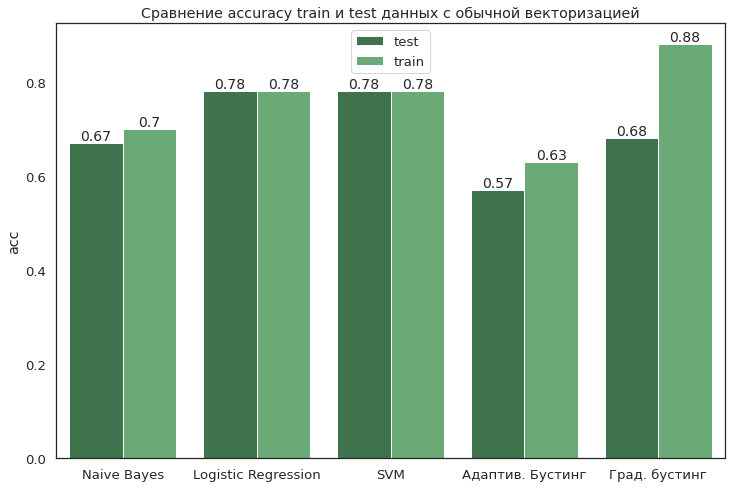

In [ ]:
sns.set(style="white", font_scale = 1.2)
fig, ax = plt.subplots(figsize=(12, 8))
pal = sns.color_palette("Greens_d", 2)
rank = np.array(range(2)).argsort().argsort()
ax = sns.barplot(y = 'acc',
                 x =  ['Naive Bayes', 'Logistic Regression','SVM', 'Адаптив. Бустинг',
                       'Град. бустинг', 'Naive Bayes', 'Logistic Regression','SVM',
                       'Адаптив. Бустинг', 'Град. бустинг'],
                 hue='var',
                 data=df_token,
                 palette=np.array(pal[::-1])[rank])
for container in ax.containers:
    ax.bar_label(container, fontsize=14)
ax.set_title('Сравнение accuracy train и test данных с обычной векторизацией')
hands, labs = ax.get_legend_handles_labels()
plt.legend(handles=hands, title='', loc='upper center', labels=['test', 'train'])

С обычной векторизацией наилучший результат у модели SVM (0.78) и Логистической регрессии (0.78). Наихудший результат получился у модели адаптивного бустинга (0.58). Градиентный бустинг показывает результаты переобучения, т.к. на тренировочной выборке accuracy достиг 0.93, а на тестовой намного меньше (0.68). Naive Bayes также дал результаты чуть превышающие 0.5

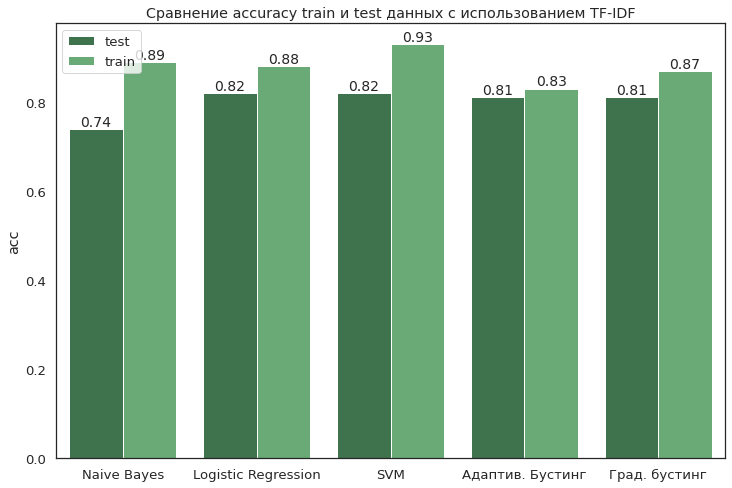

In [ ]:
sns.set(style="white", font_scale = 1.2)
fig, ax = plt.subplots(figsize=(12, 8))
pal = sns.color_palette("Greens_d", 2)
rank = np.array(range(2)).argsort().argsort()
ax = sns.barplot(y = 'acc',
                 x =  ['Naive Bayes', 'Logistic Regression','SVM',
                       'Адаптив. Бустинг', 'Град. бустинг',
                       'Naive Bayes', 'Logistic Regression','SVM',
                       'Адаптив. Бустинг', 'Град. бустинг'],
                 hue='var',
                 data=df_token_tf,
                 palette=np.array(pal[::-1])[rank])
for container in ax.containers:
    ax.bar_label(container, fontsize=14)
ax.set_title('Сравнение accuracy train и test данных с использованием TF-IDF')
hands, labs = ax.get_legend_handles_labels()
plt.legend(handles=hands, title='', loc='upper left', labels=['test', 'train'])

При использовании TF-IDF наилучший результат показала также модель .SVM и логистиеской регрессии. При этом градиентный бустинг показал результаты лучше, чем предыдущие. Наименьший результат получился у модели Naive Bayes. Также все результаты выше 0.7. Логистическая регрессия и SVM на обучающей выборке дали одинаковые результаты. Можно судить о переобучении моделей Naive Bayes, где результат на тренировочной выборке составил 0.89. Также у модели SVM переобучение (0.93)

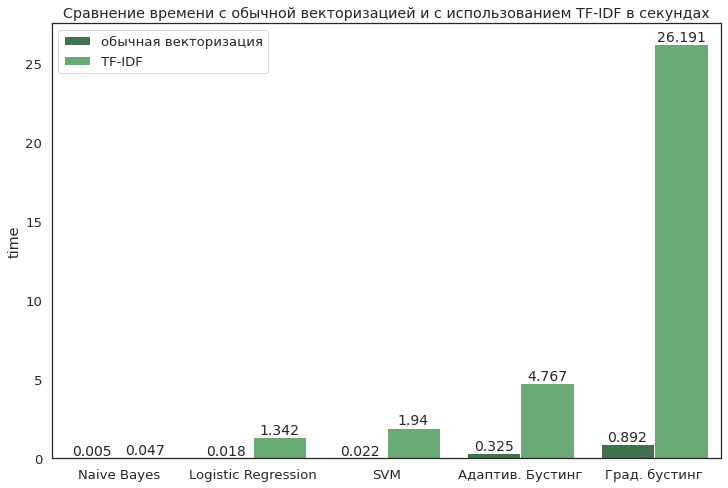

In [ ]:
sns.set(style="white", font_scale = 1.2)
fig, ax = plt.subplots(figsize=(12, 8))
pal = sns.color_palette("Greens_d", 2)
rank = np.array(range(2)).argsort().argsort()
ax = sns.barplot(y = 'time',
                 x =  ['Naive Bayes', 'Logistic Regression','SVM',
                       'Адаптив. Бустинг', 'Град. бустинг',
                       'Naive Bayes', 'Logistic Regression','SVM',
                       'Адаптив. Бустинг', 'Град. бустинг'],
                 hue='tf',
                 data=df_time,
                 palette=np.array(pal[::-1])[rank])
for container in ax.containers:
    ax.bar_label(container, fontsize=14)
ax.set_title('Сравнение времени с обычной векторизацией и с использованием TF-IDF в секундах')
hands, labs = ax.get_legend_handles_labels()
plt.legend(handles=hands, title='', loc='upper left', labels=['обычная векторизация', 'TF-IDF'])

Градиентный бустинг обучался дольше всех (порядка 30 секунд при TF-IDF), при этом имея не удовлетворительные результаты. Напротив же, Naive Bayes имеет наименьшие результаты по всем типам векторизации и также наименьшее время обучения. Наиболее положительные результаты показали модели логистической регресси и SVM, учитывая как время обучения, так и сами результаты

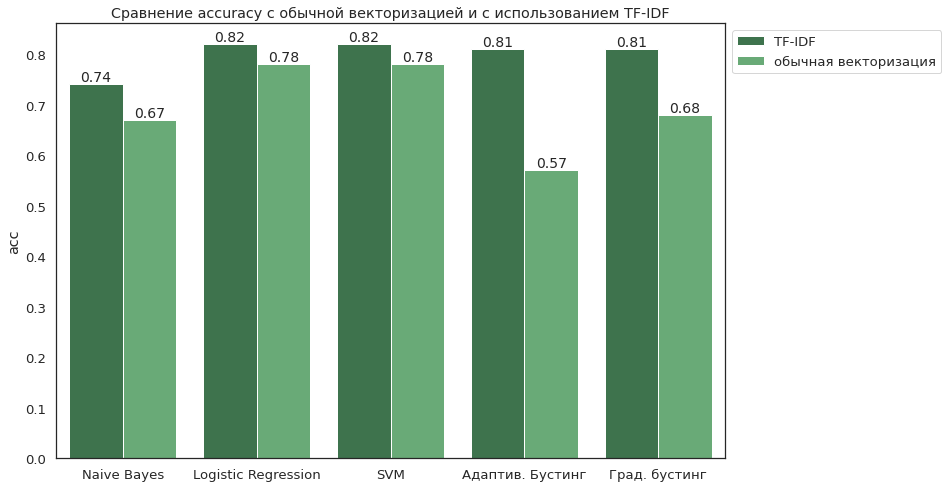

In [ ]:
sns.set(style="white", font_scale = 1.2)
fig, ax = plt.subplots(figsize=(12, 8))
pal = sns.color_palette("Greens_d", 2)
rank = np.array(range(2)).argsort().argsort()
ax = sns.barplot(y = 'acc',
                 x =  ['Naive Bayes', 'Logistic Regression','SVM',
                       'Адаптив. Бустинг', 'Град. бустинг',
                       'Naive Bayes', 'Logistic Regression','SVM',
                       'Адаптив. Бустинг', 'Град. бустинг'],
                 hue='var',
                 data=df_token_tf_and_nottf,
                 palette=np.array(pal[::-1])[rank])
for container in ax.containers:
    ax.bar_label(container, fontsize=14)
ax.set_title('Сравнение accuracy с обычной векторизацией и с использованием TF-IDF')
hands, labs = ax.get_legend_handles_labels()
plt.legend(handles=hands, title='', loc='upper left', labels=['TF-IDF', 'обычная векторизация'])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

Сравнивая показатели accuracy только на тестовой выборке, можно сказать, что использование TF-IDF значительно увеличило показатели accuracy для всех моделей машинного обучения. Адаптивный бустинг показал скачок точности на 0.3. Также стоит отметить наиболее стабильные результаты SVM модели и логистической регрессии

Также, выбирая лучшие модели, можно сравнить ошибку прогноза. В данном случае это модели SVM и логистической регрессии. В качестве ошибки применялась средняя квадратичная ошибка

In [ ]:
mse_logit_train = mean_squared_error(y_train, predicted_train_tfidf_LR)
print(f'MSE тренировочной выборки модели логистической регрессии с TF-IDF: {mse_logit_train}')

mse_logit_val = mean_squared_error(y_val, predicted_val_tfidf_LR)
print(f'MSE валидационной выборки модели логистической регрессии с TF-IDF: {mse_logit_val}')

MSE тренировочной выборки модели логистической регрессии с TF-IDF: 1.3266331658291457
MSE валидационной выборки модели логистической регрессии с TF-IDF: 1.4074941451990632


In [ ]:
mse_svm_train = mean_squared_error(y_train, predicted_train_tfidf_SVM)
print(f'MSE тренировочной выборки модели SVM с TF-IDF: {mse_svm_train}')

mse_svm_val = mean_squared_error(y_val, predicted_val_tfidf_SVM)
print(f'MSE валидационной выборки модели SVM с TF-IDF: {mse_svm_val}')

MSE тренировочной выборки модели SVM с TF-IDF: 0.13165829145728644
MSE валидационной выборки модели SVM с TF-IDF: 1.3372365339578454


Видно, что модель SVM показывает наименьшую ошибку на тренировочной выборке, что говорит о подстраивании под данные. Остальные же показатели имеют хороший результат. Модель логистическое регрессии также предсказывает результаты тренировочной выборки, как и тренировочной

Ошибка прогноза на первых 50ти элементах показана на данных графиках

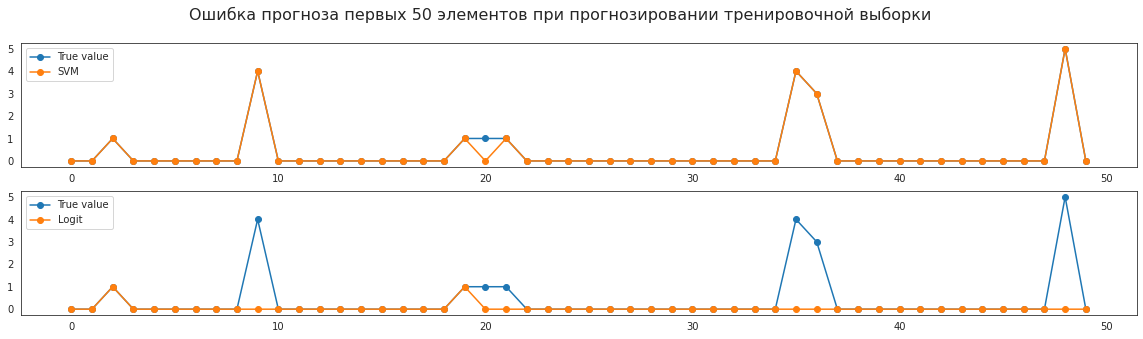

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(20,5))
sns.set_style('white')
train_svm = pd.DataFrame({
    'pred':y_train[:50],
    'svm':predicted_train_tfidf_SVM[:50]
})
train_logit = pd.DataFrame({
    'pred':y_train[:50],
    'logit':predicted_train_tfidf_LR[:50]
})
axs[0].plot(train_svm, marker='o')
axs[1].plot(train_logit, marker='o')
fig.suptitle('Ошибка прогноза первых 50 элементов при прогнозировании тренировочной выборки', fontsize=16)
axs[0].legend(['True value', 'SVM'])
axs[1].legend(['True value', 'Logit'])

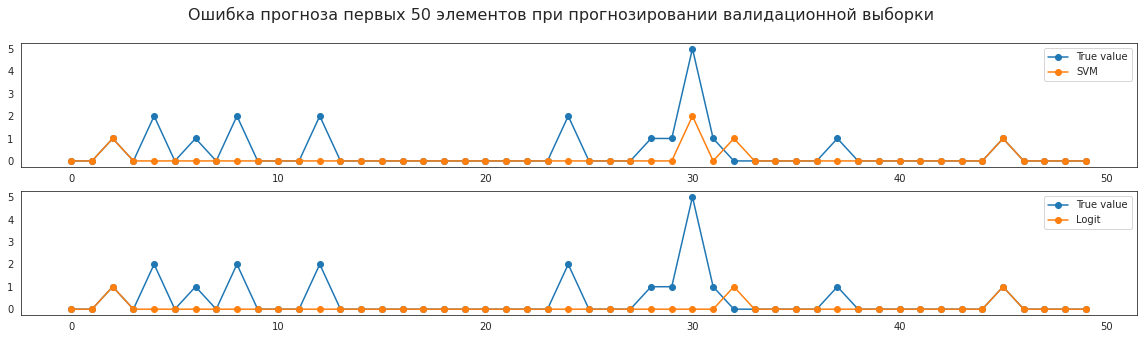

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(20,5))
sns.set_style('white')
test_svm = pd.DataFrame({
    'pred':y_val[:50],
    'svm':predicted_val_tfidf_SVM[:50]
})
test_logit = pd.DataFrame({
    'pred':y_val[:50],
    'logit':predicted_val_tfidf_LR[:50]
})
axs[0].plot(test_svm, marker='o')
axs[1].plot(test_logit, marker='o')
fig.suptitle('Ошибка прогноза первых 50 элементов при прогнозировании валидационной выборки', fontsize=16)
axs[0].legend(['True value', 'SVM'])
axs[1].legend(['True value', 'Logit'])

## Реккурентная модель

В качестве реккурентной модели использовалась модель LSTM с тремя видами эмбэдингов

#### Векторизация для LSTM

Для данной модели не подходит векторизация TF-IDF

In [ ]:
vocab_size = 3000 #размер словаря

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size)#объявление класса токенизатора после обработки
tokenizer.fit_on_texts(df2['Text_stop'])#создание словаря на основе отзывов выборки

In [ ]:
df_vect = df2

In [ ]:
#перевод токенизированных слов в массив цифр
df_vect['Tokens'] = tokenizer.texts_to_sequences(np.array(df_vect['Text_stop']))

In [ ]:
df_vect = df_vect.sample(frac=1).reset_index(drop=True)

Необходимо изменить целевую переменную с помощью метода one-hot-encoding

In [ ]:
y = df_vect['emotions']

In [ ]:
lab = LabelBinarizer()
lab.fit(y)
y_tf = lab.transform(y)

n=100
print('Кодирование категории в one-hot вектор: ' + y[n] + ' is ', y_tf[n])

Кодирование категории в one-hot вектор: happy is  [0 0 1 0 0 0]


In [ ]:
#разбиение на тестовую и тренировочную выборки
X_train, X_val, y_train, y_val = train_test_split(df_vect.Tokens.values, y_tf, test_size = 0.3, random_state=17, stratify = df_vect.emotions.values)

In [ ]:
allreviews = np.concatenate((X_train, X_val), axis=0)

In [ ]:
#смотрим максимальную и минимальную длину отзывов, а также среднее
print("Максимальная длина отзыва: {}".format(len(max((allreviews), key=len))))
print("Минимальная длина отзыва:  {}".format(len(min((allreviews), key=len))))
result = [len(x) for x in allreviews]
print("Средняя длина отзыва:      {}".format(np.mean(result)))

Максимальная длина отзыва: 17
Минимальная длина отзыва:  0
Средняя длина отзыва:      7.013669064748202


In [ ]:
#определяю усредненную длину отзыва
review_length = 8

In [ ]:
#приведение каждого отзыва к выбранной длине
x_train_lstm = sequence.pad_sequences(X_train, maxlen = review_length,padding='post')
x_val_lstm = sequence.pad_sequences(X_val, maxlen = review_length,padding='post')

In [ ]:
print(f'Размер обучающей выборки: {len(x_train_lstm)}')
print(f'Размер валидационной выборки: {len(x_val_lstm)}')

Размер обучающей выборки: 995
Размер валидационной выборки: 427


In [ ]:
predict = pd.read_csv('/content/predict_ML.csv')
train_predict = pd.read_csv('/content/train_predict_ML.csv')

#### Embedding

In [ ]:
#инициализация входного слоя
input_ = layers.Input(shape = x_train_lstm[0,:].shape,name='input')

#слой эмбеддинг
x = layers.Embedding(vocab_size+1,64,trainable=False, name='embedding')(input_)
x = layers.Bidirectional(layers.LSTM(32,dropout=0.1),name='bidirectional-lstm')(x) # LSTM layer
x = layers.Dropout(0.1, name='dropout')(x)
x = layers.Dense(64, activation='relu', name='dense')(x)
#выходной слой с функцией активации softmax
output = layers.Dense(6,activation='softmax', name='classification')(x)

model_lstm = models.Model(input_, output)

#инициализация оптимизатора и функции потерь
opt = optimizers.Adam(learning_rate=0.02, beta_1=0.9)
#компилирование модели
model_lstm.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

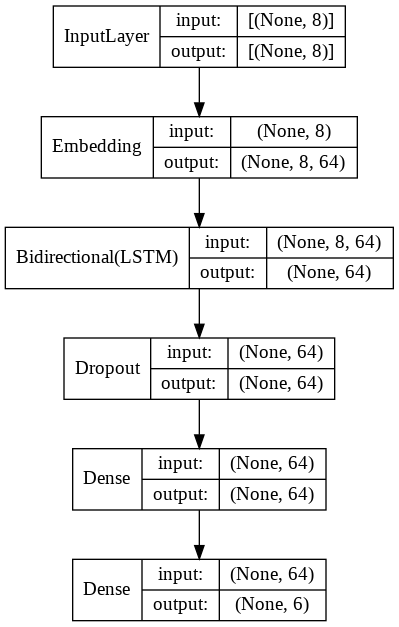

In [ ]:
tf.keras.utils.plot_model(model_lstm, to_file='model.png', show_shapes=True, show_layer_names=False)

In [ ]:
model_lstm.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 8)]               0         
                                                                 
 embedding (Embedding)       (None, 8, 64)             192064    
                                                                 
 bidirectional-lstm (Bidirec  (None, 64)               24832     
 tional)                                                         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 classification (Dense)      (None, 6)                 390       
                                                           

Также происходит оценка времени обучения каждой модели

In [ ]:
start_time = datetime.now()
#обучение модели
history_lstm = model_lstm.fit(x_train_lstm, y_train, batch_size=32, shuffle=True, epochs=6, validation_data=(x_val_lstm, y_val))
end_time = datetime.now()

training_time_lstm = (end_time - start_time).total_seconds()

Epoch 1/6
32/32 [==============================] - 4s 30ms/step - loss: 0.9007 - accuracy: 0.7608 - val_loss: 0.8112 - val_accuracy: 0.7799
Epoch 2/6
32/32 [==============================] - 0s 6ms/step - loss: 0.7888 - accuracy: 0.7809 - val_loss: 0.8047 - val_accuracy: 0.7822
Epoch 3/6
32/32 [==============================] - 0s 7ms/step - loss: 0.7552 - accuracy: 0.7980 - val_loss: 0.7709 - val_accuracy: 0.8056
Epoch 4/6
32/32 [==============================] - 0s 7ms/step - loss: 0.7123 - accuracy: 0.8020 - val_loss: 0.7611 - val_accuracy: 0.8080
Epoch 5/6
32/32 [==============================] - 0s 9ms/step - loss: 0.6936 - accuracy: 0.8040 - val_loss: 0.7627 - val_accuracy: 0.8080
Epoch 6/6
32/32 [==============================] - 0s 7ms/step - loss: 0.6371 - accuracy: 0.8050 - val_loss: 0.8059 - val_accuracy: 0.8126


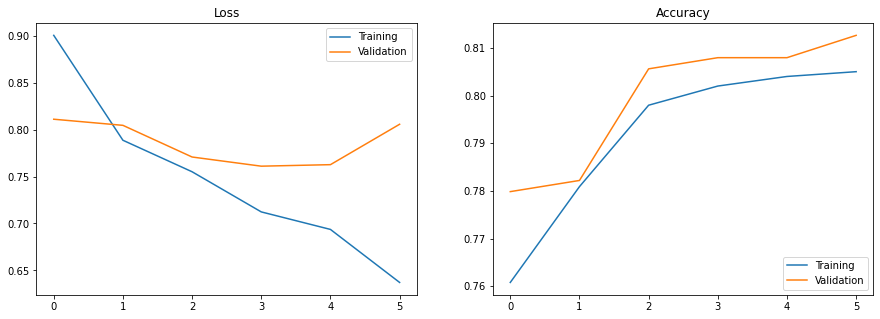

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history_lstm.history['loss'], label='Training')
ax[0].plot(history_lstm.history['val_loss'], label='Validation')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history_lstm.history['accuracy'], label='Training')
ax[1].plot(history_lstm.history['val_accuracy'], label='Validation')
ax[1].legend(loc="lower right")

В целом, снижении лосса и повышение accuracy на тестовой выборке идет почти равномерно тренировочной. Кроме последней эпохи Loss, где результат увеличился

In [ ]:
accuracy_lstm = history_lstm.history['val_accuracy'][-1]
print('Accuracy Training data: {:.1%}'.format(history_lstm.history['accuracy'][-1]))
print('Accuracy Test data: {:.1%}'.format(history_lstm.history['val_accuracy'][-1]))
print('Training time: {:.1f}s'.format(training_time_lstm))

Accuracy Training data: 80.5%
Accuracy Test data: 81.3%
Training time: 5.3s


In [ ]:
Y_pred=model_lstm.predict(x_val_lstm)
Y_pred=(Y_pred>=0.5).astype("int")
print(classification_report(y_val,Y_pred))

14/14 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       1.00      0.06      0.11        18
           1       0.00      0.00      0.00         4
           2       0.81      0.98      0.89       333
           3       1.00      0.24      0.39        49
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00        12

   micro avg       0.82      0.80      0.81       427
   macro avg       0.47      0.21      0.23       427
weighted avg       0.79      0.80      0.74       427
 samples avg       0.80      0.80      0.80       427



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
predict['val_embedding'] = lab.inverse_transform(model_lstm.predict(x_val_lstm))
train_predict['train_embedding'] = lab.inverse_transform(model_lstm.predict(x_train_lstm))
predict.to_csv('predict_ML.csv') # Сохраняем результат
train_predict.to_csv('train_predict_ML.csv') # Сохраняем результат

32/32 [==============================] - 0s 3ms/step


#### Embedding Word2Vec

In [ ]:
#инициализация словаря world2vec
w2v = api.load("word2vec-google-news-300")
w2v['hello'].shape

[==================================================] 100.0% 1662.8/1662.8MB downloaded


(300,)

In [ ]:
voc = tokenizer.word_index
reverse_voc = dict([(value, key) for (key, value) in voc.items()])

In [ ]:
vocab_size = len(voc.items())

In [ ]:
#инициализация словаря нулями
emb_matrix=np.zeros((vocab_size+1, 300))
for i in range(vocab_size):
  w = reverse_voc[i+1]
  #если в словаре нет слова, то добавить его
  if w in w2v:
    emb_matrix[i+1,:] = w2v[w]
emb_size = emb_matrix.shape[1]

In [ ]:
#получение количества категорий эмоций
nr_categories = len(df_vect["emotions"].unique())

In [ ]:
#инициализация входного слоя
input_ = layers.Input(shape = x_train_lstm[0,:].shape,name='input')

#предобученный эмбеддинг word2vec
x = layers.Embedding(vocab_size+1,emb_size,weights=[emb_matrix],trainable=False, name='embedding')(input_)
x = layers.Bidirectional(layers.LSTM(15,dropout=0.2),name='bidirectional-lstm')(x) # LSTM layer
x = layers.Dropout(0.1, name='dropout')(x)
x = layers.Dense(32, activation='relu', name='dense')(x)
output = layers.Dense(nr_categories,activation='softmax', name='classification')(x)
#выходной слой с функцией активации softmax
model_w2v = models.Model(input_, output)

#инициализация оптимизатора и функции потерь
opt = optimizers.Adam(learning_rate=0.01, beta_1=0.9)
#компилирование модели
model_w2v.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

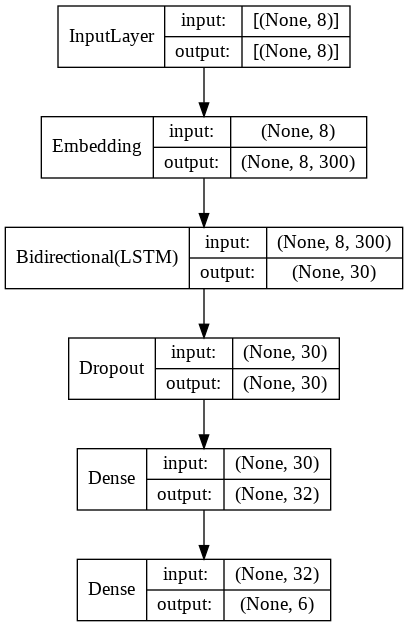

In [ ]:
tf.keras.utils.plot_model(model_w2v, to_file='model.png', show_shapes=True, show_layer_names=False)

In [ ]:
model_w2v.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 8)]               0         
                                                                 
 embedding (Embedding)       (None, 8, 300)            802500    
                                                                 
 bidirectional-lstm (Bidirec  (None, 64)               85248     
 tional)                                                         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 classification (Dense)      (None, 6)                 198       
                                                          

In [ ]:
start_time = datetime.now()
#обучение модели
history_w2v = model_w2v.fit(x_train_lstm, y_train, batch_size=64, shuffle=True, epochs=6, validation_data=(x_val_lstm, y_val))
end_time = datetime.now()

training_time_w2v = (end_time - start_time).total_seconds()

Epoch 1/6
16/16 [==============================] - 4s 60ms/step - loss: 0.9900 - accuracy: 0.7568 - val_loss: 0.7844 - val_accuracy: 0.7799
Epoch 2/6
16/16 [==============================] - 0s 12ms/step - loss: 0.7341 - accuracy: 0.7899 - val_loss: 0.6791 - val_accuracy: 0.8103
Epoch 3/6
16/16 [==============================] - 0s 11ms/step - loss: 0.6041 - accuracy: 0.8181 - val_loss: 0.6189 - val_accuracy: 0.8150
Epoch 4/6
16/16 [==============================] - 0s 11ms/step - loss: 0.4837 - accuracy: 0.8432 - val_loss: 0.6105 - val_accuracy: 0.8150
Epoch 5/6
16/16 [==============================] - 0s 14ms/step - loss: 0.3876 - accuracy: 0.8673 - val_loss: 0.5882 - val_accuracy: 0.8384
Epoch 6/6
16/16 [==============================] - 0s 12ms/step - loss: 0.3178 - accuracy: 0.8935 - val_loss: 0.6779 - val_accuracy: 0.8314


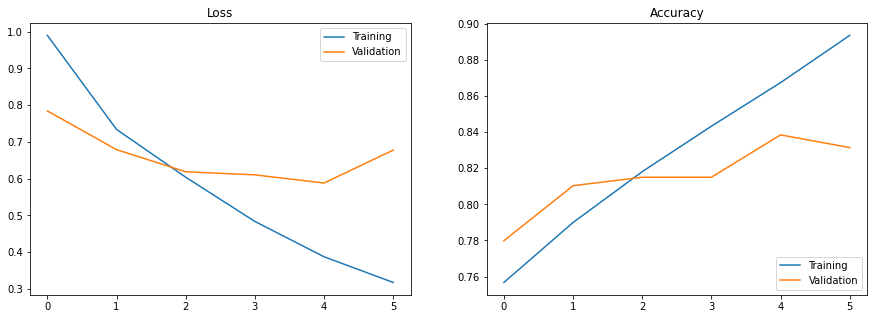

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history_w2v.history['loss'], label='Training')
ax[0].plot(history_w2v.history['val_loss'], label='Validation')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history_w2v.history['accuracy'], label='Training')
ax[1].plot(history_w2v.history['val_accuracy'], label='Validation')
ax[1].legend(loc="lower right")

На тренировочной выборке снижение loss и повышение точности происходит равномерно. В свою очередь на тестовой выборке loss начинает падать с 0.79 и доходит минимально только до ~0.6 (4 эпоха). Точность же имеет скачки на 3 и 4 эпохах, в которых достигаются наибольшее значение, а затем его падение. Стоит отметить, если увеличивается количетсво эпох, то модель переобучается и показатели accuracy уменьшаются, а loss - увеличивается

In [ ]:
accuracy_w2v = history_w2v.history['val_accuracy'][-1]
print('Accuracy Training data: {:.1%}'.format(history_w2v.history['accuracy'][-1]))
print('Accuracy Test data: {:.1%}'.format(history_w2v.history['val_accuracy'][-1]))
print('Training time: {:.1f}s'.format(training_time_w2v))

Accuracy Training data: 89.3%
Accuracy Test data: 83.1%
Training time: 4.8s


In [ ]:
predict['val_embedding_w2v'] = lab.inverse_transform(model_w2v.predict(x_val_lstm))
train_predict['train_embedding_w2v'] = lab.inverse_transform(model_w2v.predict(x_train_lstm))
predict['val_embedding_w2v'] = predict['val_embedding_w2v'].map(label_dict)
train_predict['train_embedding_w2v']  = train_predict['train_embedding_w2v'].map(label_dict)
predict.to_csv('predict_ML.csv') # Сохраняем результат
train_predict.to_csv('train_predict_ML.csv') # Сохраняем результат

32/32 [==============================] - 0s 2ms/step


#### Embedding GloVe

In [ ]:
#загрузка словаря GloVe
try:
  !wget -P DATAPATH http://nlp.stanford.edu/data/glove.6B.zip
  !unzip DATAPATH/glove.6B.zip -d DATAPATH/glove.6B

  BASE_DIR = 'DATAPATH'

except ModuleNotFoundError:

    if not os.path.exists('Data/glove.6B'):
        os.mkdir('Data/glove.6B')

        url='http://nlp.stanford.edu/data/glove.6B.zip'
        wget.download(url,'Data')

        temp='Data/glove.6B.zip'
        file = ZipFile(temp)
        file.extractall('Data/glove.6B')
        file.close()

    BASE_DIR = 'Data'

--2022-11-05 12:01:40--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-11-05 12:01:40--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-11-05 12:01:41--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘DATAPATH/glove.6B.z

In [ ]:
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')
MAX_SEQUENCE_LENGTH = 8
MAX_NUM_WORDS = vocab_size
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [ ]:
embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'),encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Найдено %s векторов слов в словаре' % len(embeddings_index))

Найдено 400000 векторов слов в словаре


In [ ]:
# подготовить матрицу встраивания - строки - это слова из word_index, столбцы - это вложения этого слова из GLOVE.
num_words = min(MAX_NUM_WORDS, len(voc)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in voc.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # слова, не найденные в embeddings_index, будут состоять из нулей.
        embedding_matrix[i] = embedding_vector

In [ ]:
#инициализация входного слоя
input_ = layers.Input(shape = x_train_lstm[0,:].shape,name='input')

#инициализация слоя эмбэдинга
x = layers.Embedding(num_words,
                    EMBEDDING_DIM,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False)(input_)
x = layers.Bidirectional(layers.LSTM(15,dropout=0.2),name='bidirectional-lstm')(x) # LSTM layer
x = layers.Dropout(0.2, name='dropout')(x)
x = layers.Dense(32, activation='relu', name='dense')(x)
#выходной слой с функцией активации softmax
output = layers.Dense(nr_categories,activation='softmax', name='classification')(x)

model_glove = models.Model(input_, output)
#инициализация оптимизатора и функции потерь
opt = optimizers.Adam(learning_rate=0.01, beta_1=0.9)
#компилирование модели
model_glove.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

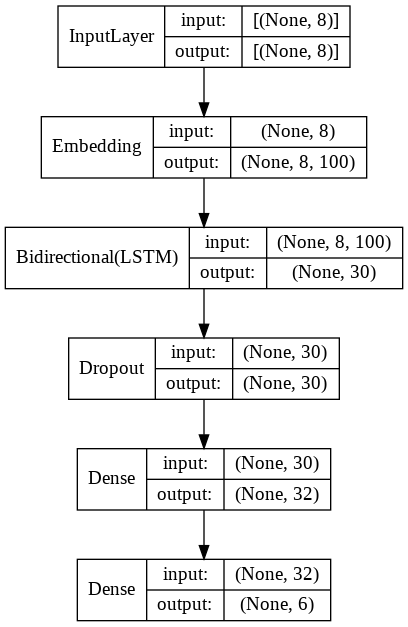

In [ ]:
tf.keras.utils.plot_model(model_glove, to_file='model.png', show_shapes=True, show_layer_names=False)

In [ ]:
model_glove.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 8)]               0         
                                                                 
 embedding (Embedding)       (None, 8, 100)            267500    
                                                                 
 bidirectional-lstm (Bidirec  (None, 30)               13920     
 tional)                                                         
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense (Dense)               (None, 32)                992       
                                                                 
 classification (Dense)      (None, 6)                 198       
                                                          

In [ ]:
start_time = datetime.now()
#обучение модели
history_glove = model_glove.fit(x_train_lstm, y_train, batch_size=32, shuffle=True, epochs=6, validation_data=(x_val_lstm, y_val))
end_time = datetime.now()

training_time_glove = (end_time - start_time).total_seconds()

Epoch 1/6
32/32 [==============================] - 9s 31ms/step - loss: 0.9347 - accuracy: 0.7729 - val_loss: 0.7428 - val_accuracy: 0.8080
Epoch 2/6
32/32 [==============================] - 0s 8ms/step - loss: 0.7283 - accuracy: 0.8050 - val_loss: 0.6917 - val_accuracy: 0.8103
Epoch 3/6
32/32 [==============================] - 0s 7ms/step - loss: 0.6543 - accuracy: 0.8131 - val_loss: 0.6741 - val_accuracy: 0.8244
Epoch 4/6
32/32 [==============================] - 0s 8ms/step - loss: 0.5743 - accuracy: 0.8302 - val_loss: 0.6594 - val_accuracy: 0.8244
Epoch 5/6
32/32 [==============================] - 0s 8ms/step - loss: 0.4921 - accuracy: 0.8553 - val_loss: 0.6469 - val_accuracy: 0.8150
Epoch 6/6
32/32 [==============================] - 0s 9ms/step - loss: 0.4260 - accuracy: 0.8693 - val_loss: 0.7055 - val_accuracy: 0.8267


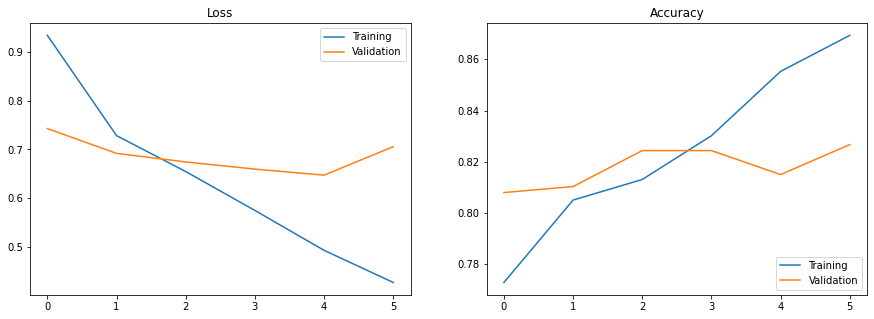

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history_glove.history['loss'], label='Training')
ax[0].plot(history_glove.history['val_loss'], label='Validation')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history_glove.history['accuracy'], label='Training')
ax[1].plot(history_glove.history['val_accuracy'], label='Validation')
ax[1].legend(loc="lower right")

При обучении данной модели падение loss-а и увеличение accuracy также имеет равномерный характер. Однако loss на тестовой выборке на 1 эпохе упал, после чего начал увеличиваться, что может служить фактором переобучения. Accuracy резко поднимается на 2 эпохе, на 3 - падает, а на 4 резко увеличивается. Результаты хуже, чем при использовании word2vec эмбединга.

In [ ]:
accuracy_glove = history_glove.history['val_accuracy'][-1]
print('Accuracy Training data: {:.1%}'.format(history_glove.history['accuracy'][-1]))
print('Accuracy Test data: {:.1%}'.format(history_glove.history['val_accuracy'][-1]))
print('Training time: {:.1f}s'.format(training_time_glove))

Accuracy Training data: 86.9%
Accuracy Test data: 82.7%
Training time: 10.1s


In [ ]:
predict['val_embedding_glove'] = lab.inverse_transform(model_glove.predict(x_val_lstm))
train_predict['train_embedding_glove'] = lab.inverse_transform(model_glove.predict(x_train_lstm))
predict.to_csv('predict_ML.csv') # Сохраняем результат
train_predict.to_csv('train_predict_ML.csv') # Сохраняем результат

32/32 [==============================] - 0s 2ms/step


### Сравнение Embedding-ов

Так же, как и при сравнении обычных моделей, для удобства построения графиков создается датафрейм и массивы

In [ ]:
arr_acc_val = [accuracy_lstm, accuracy_w2v, accuracy_glove]
arr_acc_train = [history_lstm.history['accuracy'][-1], history_w2v.history['accuracy'][-1], history_glove.history['accuracy'][-1]]
arr_time = [training_time_lstm, training_time_w2v, training_time_glove]

In [ ]:
df_acc = pd.DataFrame({'var': [0,0,0,1,1,1],
           'acc': [round(accuracy_lstm, 3), round(accuracy_w2v,3), round(accuracy_glove, 3), round(history_lstm.history['accuracy'][-1],3), round(history_w2v.history['accuracy'][-1],3), round(history_glove.history['accuracy'][-1],3)]
           })

Text(0.5, 1.0, 'Сравнение accuracy на валидационной выборке с разными эмбедингами')

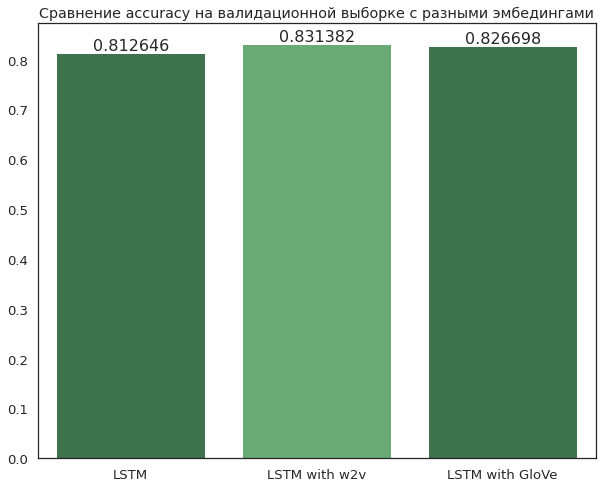

In [ ]:
sns.set(style="white", font_scale = 1.2)
fig, ax = plt.subplots(figsize=(10, 8))
pal = sns.color_palette("Greens_d", 2)
rank = np.array(range(2)).argsort().argsort()
ax = sns.barplot(y = arr_acc_val, x =  ['LSTM', 'LSTM with w2v','LSTM with GloVe'], palette=np.array(pal[::-1])[rank])
for container in ax.containers:
    ax.bar_label(container, fontsize=16)
ax.set_title('Сравнение accuracy на валидационной выборке с разными эмбедингами')

Наилучший результат показал эмбединг GloVe, наименьший - собственный

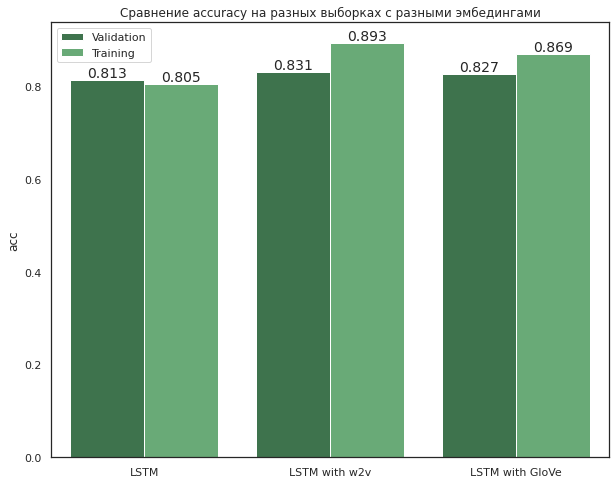

In [ ]:
sns.set(style="white", font_scale = 1)
fig, ax = plt.subplots(figsize=(10, 8))
pal = sns.color_palette("Greens_d", 2)
rank = np.array(range(2)).argsort().argsort()
ax = sns.barplot(y = 'acc',
                 x =  ['LSTM', 'LSTM with w2v','LSTM with GloVe', 'LSTM', 'LSTM with w2v','LSTM with GloVe'],
                 hue = 'var',
                 data = df_acc,
                 palette=np.array(pal[::-1])[rank])
for container in ax.containers:
    ax.bar_label(container, fontsize=14)
ax.set_title('Сравнение accuracy на разных выборках с разными эмбедингами')
hands, labs = ax.get_legend_handles_labels()
plt.legend(handles=hands, title='', loc='upper left', labels=['Validation', 'Training'])

на данном графике видно, что модель с word2vec на тренировочной выборке имеет наибольший результат - 0.89, что больше, чем у модели с GloVe, которая при этом имеет лучший результат на обучающей выборке на 0.01

Text(0.5, 1.0, 'Сравнение времени обучения в секундах с разными эмбедингами')

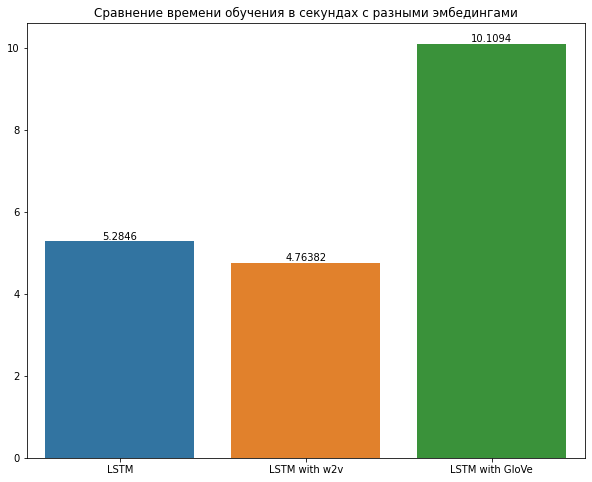

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.barplot(y = arr_time, x =  ['LSTM', 'LSTM with w2v','LSTM with GloVe'])
for container in ax.containers:
    ax.bar_label(container)
ax.set_title('Сравнение времени обучения в секундах с разными эмбедингами')

При этом время обучения показывает, что модель с собственным эмбедингом обучалась дольше, чем с предобученными эмбедингами. Исходя из времени обучения, стабильная модель - модель с использованием word2vec

Также расчитываюошибку прогноза для лучшей модели с эмбедингом Word2vec

In [ ]:
mse_embedding_train = mean_squared_error(y_train, model_w2v.predict(x_train_lstm))
mse_embedding_val = mean_squared_error(y_val, model_w2v.predict(x_val_lstm))

14/14 [==============================] - 0s 3ms/step


In [ ]:
print(f'MSE тренировочной выборки модели lstm с emmbeding-ом Word2vec: {mse_embedding_train}')
print(f'MSE валидационной выборки модели lstm с emmbeding-ом Word2vec: {mse_embedding_val}')

MSE тренировочной выборки модели lstm с emmbeding-ом Word2vec: 0.01597443219640532
MSE валидационной выборки модели lstm с emmbeding-ом Word2vec: 0.0452357452426487


Вспомогательные строки кода для отрисовки графика первых 50ти предсказанных значений

In [ ]:
predict['val_embedding_w2v'] = predict['val_embedding_w2v'].map(label_dict)
train_predict['train_embedding_w2v']  = train_predict['train_embedding_w2v'].map(label_dict)

In [ ]:
y_train_2 = lab.inverse_transform(y_train)
train_w2v = pd.DataFrame({
    'pred':y_train_2
})
train_w2v['pred'] = train_w2v['pred'].map(label_dict)
train_w2v['w2v'] = train_predict['train_embedding_w2v']

In [ ]:
y_test_2 = lab.inverse_transform(y_val)
test_w2v = pd.DataFrame({
    'pred':y_test_2
})
test_w2v['pred'] = test_w2v['pred'].map(label_dict)
test_w2v['w2v'] = predict['val_embedding_w2v']

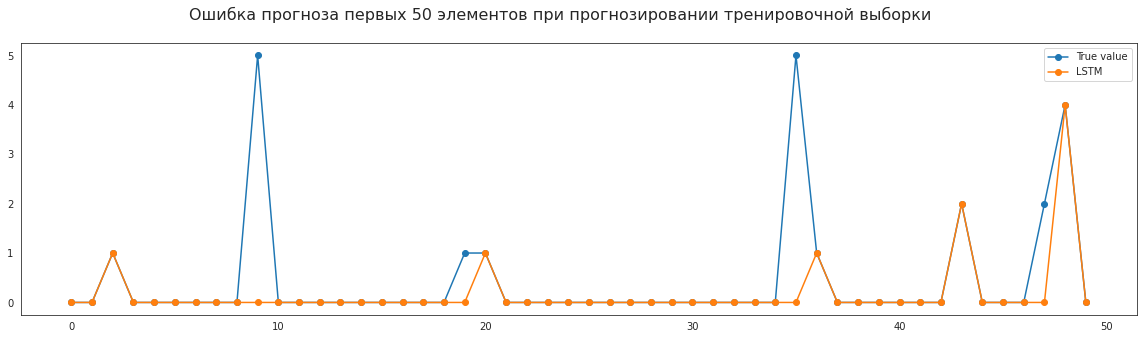

In [ ]:
fig, axes = plt.subplots(figsize=(20,5))
sns.set_style('white')
axes.plot(train_w2v[:50], marker='o')
fig.suptitle('Ошибка прогноза первых 50 элементов при прогнозировании тренировочной выборки', fontsize=16)
axes.legend(['True value', 'LSTM'])

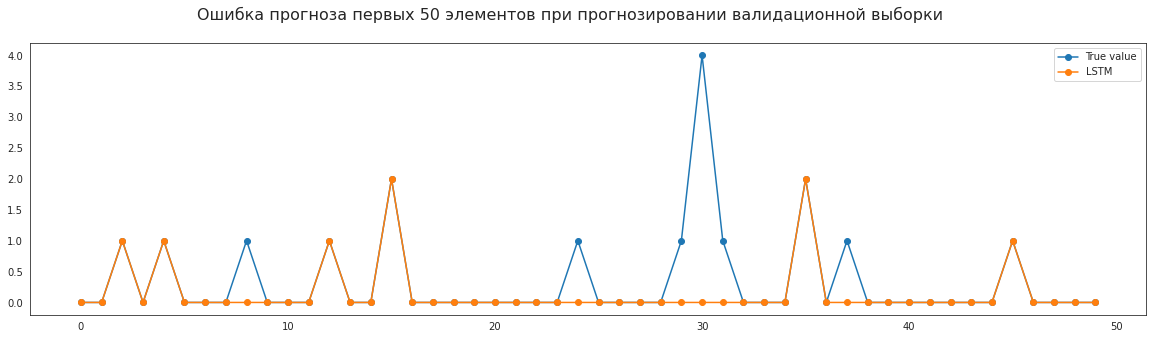

In [ ]:
fig, axes = plt.subplots(figsize=(20,5))
sns.set_style('white')
axes.plot(test_w2v[:50], marker='o')
fig.suptitle('Ошибка прогноза первых 50 элементов при прогнозировании валидационной выборки', fontsize=16)
axes.legend(['True value', 'LSTM'])

## Трансформер BERT

Для реализации данной модели данные загружаю заново, т.к. для обучения не нужно использовать лемматизацию, стеминг и другие виды нормализации кроме удаления некоторых символов рекурсивными выражениями

In [ ]:
#обновление индексов
df3 = df3.reset_index(drop=True)

In [ ]:
#обновление индексов
df2 = df2.reset_index(drop=True)

In [ ]:
#приведение к нижнему регистру
df2['TextAfterEdit'] = df2['TextAfterEdit'].str.lower()

In [ ]:
df2.head()

,Text,emotions,TextAfterEdit
0,Dorian Gray with Rainbow Scarf #LoveWins (from @britishmuseum http://t.co/Q4XSwL0esu) http://t.co/h0evbTBWRq,happy,dorian gray with rainbow scarf from
1,@SelectShowcase @Tate_StIves ... Replace with your wish which the artist uses in next installation! It was entralling!,happy,replace with your wish which the artist uses in next installation it was entralling
2,@Sofabsports thank you for following me back. Great to hear from a diverse &amp; interesting panel #DefeatingDepress...,happy,thank you for following me back great to hear from a diverse amp interesting panel
3,@britishmuseum @TudorHistory What a beautiful jewel / portrait. Is the 'R' for Rex ?,happy,what a beautiful jewel portrait is the r for rex
4,@NationalGallery @ThePoldarkian I have always loved this painting.,happy,i have always loved this painting


In [ ]:
X_test_1 = df3.TextAfterEdit.values

In [ ]:
X_test_1

array([' say wot mate',
       'Two workshops on evaluating audience engagement early July ',
       'A Forest Road by Thomas Gainsborough Oil on Canvas ', ...,
       'Were following in the footsteps of the Buddha tomorrow with ',
       ' Upper arm guard', ' Experience from perspective '], dtype=object)

In [ ]:
#разбиение на тренировочную и тестовую выборки
X_train, X_val, y_train, y_val = train_test_split(df2.TextAfterEdit.values, df2.emotions.values, test_size = 0.15, random_state=17, stratify = df2.emotions.values)

In [ ]:
#объявление нового столбца, отвечающего за тип выборки
df2['data_type'] = ['not_set']*df2.shape[0]

In [ ]:
df2.head()

,Text,emotions,TextAfterEdit,data_type
0,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy,dorian gray with rainbow scarf from,not_set
1,@SelectShowcase @Tate_StIves ... Replace with ...,happy,replace with your wish which the artist uses ...,not_set
2,@Sofabsports thank you for following me back. ...,happy,thank you for following me back great to hear...,not_set
3,@britishmuseum @TudorHistory What a beautiful ...,happy,what a beautiful jewel portrait is the r for ...,not_set
4,@NationalGallery @ThePoldarkian I have always ...,happy,i have always loved this painting,not_set


In [ ]:
#в соответствии с поделенным ранее набором данных датасет разбивается на train и test
df2.loc[df2['TextAfterEdit'].isin(X_train), 'data_type'] = 'train'
df2.loc[df2['TextAfterEdit'].isin(X_val), 'data_type'] = 'val'

In [ ]:
#группировка по каждой категории и типу выборки
df2.groupby(['emotions', 'data_type']).count()

Text  TextAfterEdit
emotions     data_type                     
angry        train        50             50
             val          10             10
disgust      train        10             10
             val           3              3
happy        train       934            934
             val         174            174
not-relevant train       113            113
             val          50             50
sad          train        31             31
             val           6              6
surprise     train        35             35
             val           6              6

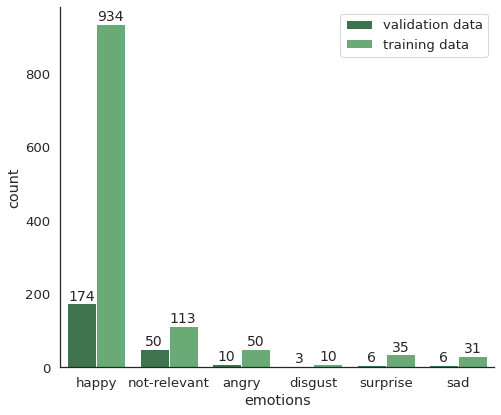

In [ ]:
sns.set(style="white", font_scale = 1.2)
pal = sns.color_palette("Greens_d", 2)
rank = np.array(range(2)).argsort().argsort()
ax = sns.catplot(data = df2 ,
                 hue = 'data_type',
                 x = 'emotions',
                 kind='count',
                 palette=np.array(pal[::-1])[rank],
                 height=6, aspect=1.2,legend=False)
ax = ax.facet_axis(0, 0)
for container in ax.containers:
    ax.bar_label(container, fontsize=14)
ax.legend(handles=hands, title='', loc='upper right', labels=['validation data', 'training data'])

На графике можно заметить, что для 4 категории очень мало данных для обучения, что может послужить тому, что данная категория распознаваться не будет. Также такое предположение можно сделать для категорий 6 и 8

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 4.8 MB/s 
     |████████████████████████████████| 182 kB 75.2 MB/s 
     |████████████████████████████████| 7.6 MB 49.0 MB/s 


In [ ]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [ ]:
#инициализация токенизатора Bert
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
import torch

In [ ]:
#преобразование тренировочной выборки в вектора
encoded_data_train = tokenizer.batch_encode_plus(
    df2[df2.data_type=='train'].TextAfterEdit.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

#преобразование тестовой выборки в вектора
encoded_data_val = tokenizer.batch_encode_plus(
    df2[df2.data_type=='val'].TextAfterEdit.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

#разделение векторов в маску и входные данные
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
#преобразование тренировочных категорий в тензоры
labels_train = torch.tensor(df2[df2.data_type=='train'].emotions.values)

#разделение векторов в маску и входные данные
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
#преобразование тестовых категорий в тензоры
labels_val = torch.tensor(df2[df2.data_type=='val'].emotions.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
dataset_train = TensorDataset(input_ids_train,
                              attention_masks_train,
                              labels_train)

dataset_val = TensorDataset(input_ids_val,
                            attention_masks_val,
                           labels_val)

In [ ]:
print(f'Размер тренировочных данных: {len(dataset_train)}')
print(f'Размер тестовых данных: {len(dataset_val)}')

Размер тренировочных данных: 1172
Размер тестовых данных: 250


In [ ]:
print('Пример векторизованного тестового тензора с входными данными, маской и категориями')
dataset_val.tensors

Пример векторизованного тестового тензора с входными данными, маской и категориями


(tensor([[ 101, 5672, 2007,  ...,    0,    0,    0],
         [ 101, 5341, 2204,  ...,    0,    0,    0],
         [ 101, 2031, 2017,  ...,    0,    0,    0],
         ...,
         [ 101, 2551, 2006,  ...,    0,    0,    0],
         [ 101, 1037, 3835,  ...,    0,    0,    0],
         [ 101, 1996, 1050,  ...,    0,    0,    0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 6, 0, 0, 2, 0, 0, 0, 0,
         0, 0, 0, 2, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0,
         0, 0, 0, 1, 0, 0, 1, 0, 0, 6, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 2, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
         0, 0, 0, 0, 1, 8, 0, 1, 0,

In [ ]:
from transformers import BertForSequenceClassification

In [ ]:
#инициализация модели
model = BertForSequenceClassification.from_pretrained(
                                      'bert-base-uncased',
                                      num_labels = len(label_dict),
                                      output_attentions = False,
                                      output_hidden_states = False
                                     )

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [ ]:
#размер батча для обучения
batch_size = 4

#инициализация DataLoader-ов
dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_val = DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=32
)

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [ ]:
#инициализация оптимизатора
optimizer = AdamW(
    model.parameters(),
    lr = 1e-5,
    eps = 1e-8
)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
epochs = 10

#инициализация scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps = len(dataloader_train)*epochs
)

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
#метод для вычисления F1-score во время обучения
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')

In [ ]:
#метод для вычисления правильно предсказанных твитов
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Категория: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
import random
import numpy as np

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in tqdm(dataloader_val):

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [ ]:
arr_train_loss, arr_val_loss, arr_score, arr_score_train = [],[],[], []

In [ ]:
start_time = datetime.now()
for epoch in tqdm(range(1, epochs+1)):
    model.train()
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train,
                        desc='Epoch {:1d}'.format(epoch),
                        leave=False,
                        disable=False)

    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }

        outputs = model(**inputs)
        loss = outputs[0]
        loss_train_total +=loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_val)
    train_loss, pred_train, true_vals_train = evaluate(dataloader_train)
    val_f1 = f1_score_func(predictions, true_vals)
    train_f1 = f1_score_func(pred_train, true_vals_train)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')
    arr_train_loss.append(train_loss)
    arr_val_loss.append(val_loss)
    arr_score.append(val_f1)
    arr_score_train.append(train_f1)
end_time = datetime.now()
training_time_bert= (end_time - start_time).total_seconds()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.8508762856104618


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

Validation loss: 0.6095826998353004
F1 Score (weighted): 0.8187502126067288


Epoch 2:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.5096333783731097


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

Validation loss: 0.48495824448764324
F1 Score (weighted): 0.8515808931151282


Epoch 3:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.32616221672328216


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

Validation loss: 0.4058766635134816
F1 Score (weighted): 0.8736921767846181


Epoch 4:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.20474051144669325


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

Validation loss: 0.47887274995446205
F1 Score (weighted): 0.8580735248158121


Epoch 5:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.1318548006262669


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

Validation loss: 0.5241420697420835
F1 Score (weighted): 0.8872989307298931


Epoch 6:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.10127944087475448


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

Validation loss: 0.49432725910446607
F1 Score (weighted): 0.8908083763203767


Epoch 7:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.06515725287560296


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

Validation loss: 0.5254010930657387
F1 Score (weighted): 0.8941713356370647


Epoch 8:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.047801204110631566


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

Validation loss: 0.5999336615204811
F1 Score (weighted): 0.8947092551572


Epoch 9:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.03290313857582482


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

Validation loss: 0.5278204486239702
F1 Score (weighted): 0.8941713356370647


Epoch 10:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.024800032908387948


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

Validation loss: 0.5634163748472929
F1 Score (weighted): 0.8908083763203767


In [ ]:
df_loss_bert = pd.DataFrame({'Validation loss ': arr_val_loss,
           'Training loss': arr_train_loss
           })
df_acc_bert = pd.DataFrame({'Validation score ': arr_score,
           'Training score': arr_score_train
           })

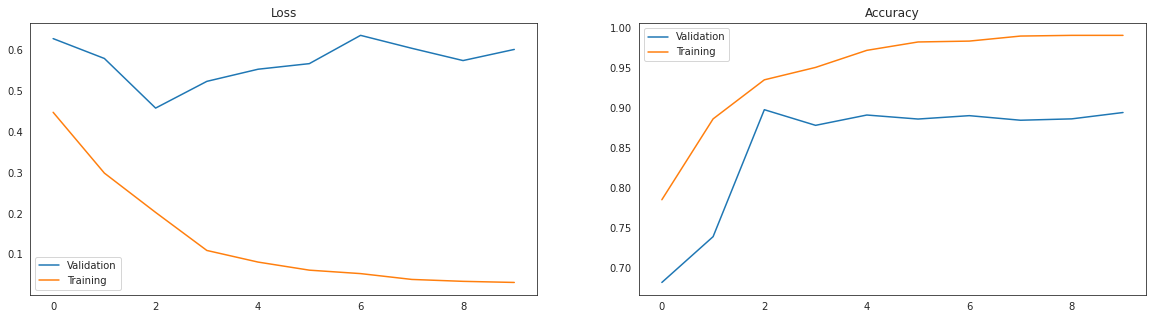

In [ ]:
fig = plt.figure(figsize=(20,5))
sns.set_style('white')
ax_1 = fig.add_subplot(1, 2, 1)
ax_2 = fig.add_subplot(1, 2, 2)
ax_1.plot(df_loss_bert)
ax_2.plot(df_acc_bert)
ax_1.set_title('Loss')
ax_2.set_title('Accuracy')
ax_1.legend(['Validation','Training'])
ax_2.legend(['Validation','Training'])

На графике видно, что loss падает равномерно на тренировочной выборке, однако на валидационной выборке он почти не изменяется. Резкое падение на 2 эпохе, увеличение на 4 и ещё раз увеличение на 7 эпохе. В свою очередь accuracy увеличивается как на тренировочной, так и на валидационной выборках, имея резкое увеличение на 2 эпохе, падение на 3 и дальнейшее плавное миниимальное увеличение, которое к концу прекращает расти

In [ ]:
val_loss, predictions, true_vals = evaluate(dataloader_val)
predictions = np.argmax(predictions, axis=1).flatten()

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
train_loss, predictions_train, true_vals_train = evaluate(dataloader_train)
predictions_train = np.argmax(predictions_train, axis=1).flatten()

  0%|          | 0/288 [00:00<?, ?it/s]

In [ ]:
#матрица метрик
predictions=(predictions>=0.5).astype("int")
print(classification_report(true_vals,predictions))
print(confusion_matrix(true_vals,predictions))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       172
           1       0.73      0.85      0.79        48
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         5

    accuracy                           0.88       239
   macro avg       0.28      0.31      0.29       239
weighted avg       0.81      0.88      0.84       239

[[169   3   0   0   0   0]
 [  7  41   0   0   0   0]
 [  2   6   0   0   0   0]
 [  0   1   0   0   0   0]
 [  1   4   0   0   0   0]
 [  4   1   0   0   0   0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
accuracy_bert = accuracy_score(true_vals,predictions)
accuracy_bert_train = accuracy_score(true_vals_train,predictions_train)
print('Accuracy Training data: {:.1%}'.format(accuracy_bert_train))
print('Accuracy Test data: {:.1%}'.format(accuracy_bert))
print('Training time: {:.1f}s'.format(training_time_bert))

Accuracy Training data: 99.5%
Accuracy Test data: 90.0%
Training time: 831.6s


Количество правильно предсказанных твитов к общему количеству твитов для валидации

In [ ]:
val_loss, predictions, true_vals = evaluate(dataloader_val)
accuracy_per_class(predictions, true_vals)

  0%|          | 0/8 [00:00<?, ?it/s]

Class: happy
Accuracy:166/172

Class: not-relevant
Accuracy:42/48

Class: angry
Accuracy:5/8

Class: disgust
Accuracy:0/1

Class: sad
Accuracy:0/5

Class: surprise
Accuracy:2/5



Таким образом, две категории модель не смогла предсказать совсем. В остальных категориях она предсказала больше 70% (кроме категории surprise)

In [ ]:
#метод для предсказания категории
def predict(text):
    #также предобработка входного текста
    text_encod = [re.sub(r"@[\w'._+-]+", '', i, flags=re.IGNORECASE) for i in text]
    text_encod = [re.sub(r"#[\w'._+-]+", '', i, flags=re.IGNORECASE) for i in text_encod]
    text_encod = [re.sub(r"https?://[^,\s]+,?", '', i, flags=re.IGNORECASE) for i in text_encod]
    text_encod = [i.replace('[^\w\s]','') for i in text_encod]
    text_encod = [re.sub(r'[^\w\s]+|[\d]+', '', i, flags=re.IGNORECASE) for i in text_encod]
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    text_encod = [re.sub(RE_WSPACE, ' ', i) for i in text_encod]

    predictions = []

    for i in text_encod:
      #токенизация текста
      encoding = tokenizer.encode_plus(
          i,
          add_special_tokens=True,
          return_token_type_ids=False,
          truncation=True,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt',
      )
      out = {
            'text': i,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

      input_ids = out["input_ids"].to(device)
      attention_mask = out["attention_mask"].to(device)

      #предсказание для всех категорий
      outputs = model(
          input_ids=input_ids.unsqueeze(0),
          attention_mask=attention_mask.unsqueeze(0)
      )

      #выбор категории по наибольшему значению
      predictions.append(torch.argmax(outputs.logits, dim=1).cpu().numpy()[0])

    return predictions

In [ ]:
predict_bert = predict(X_test_1)

TypeError: ignored

In [ ]:
predict_train_bert = predict(X_train)
predict_test_bert = predict(X_val)

Ошибка прогноза для проверки правильности работы модели. Если бы ошибка была большой, это говорило бы о неправильном обучении модели

In [ ]:
mse_bert_train = mean_squared_error(y_train, predict_train_bert)
mse_bert_test = mean_squared_error(y_val, predict_test_bert)

In [ ]:
print(f'MSE тренировочной выборки модели Bert: {mse_bert_train}')
print(f'MSE валидационной выборки модели Bert: {mse_bert_test}')

MSE тренировочной выборки модели Bert: 0.03810330228619814
MSE валидационной выборки модели Bert: 0.7464114832535885


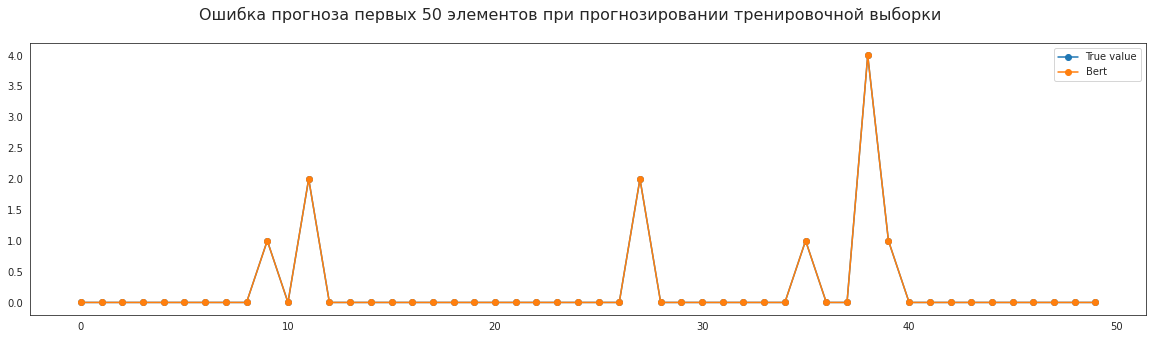

In [ ]:
fig, axes = plt.subplots(figsize=(20,5))
sns.set_style('white')
train_bert = pd.DataFrame({
     'pred':y_train,
     'bert':predict_train_bert
})
axes.plot(train_bert[:50], marker='o')
fig.suptitle('Ошибка прогноза первых 50 элементов при прогнозировании тренировочной выборки', fontsize=16)
axes.legend(['True value', 'Bert'])

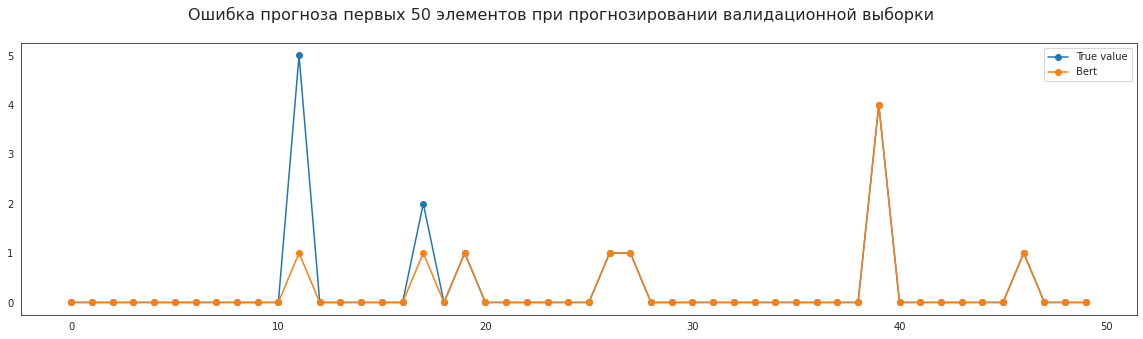

In [ ]:
fig, axes = plt.subplots(figsize=(20,5))
sns.set_style('white')
test_bert = pd.DataFrame({
     'pred':y_val,
     'bert':predict_test_bert
})
axes.plot(test_bert[:50], marker='o')
fig.suptitle('Ошибка прогноза первых 50 элементов при прогнозировании валидационной выборки', fontsize=16)
axes.legend(['True value', 'Bert'])

In [ ]:
predict_bert = pd.DataFrame()
train_predict_bert = pd.DataFrame()
predict_bert['val'] = predict_test_bert
train_predict_bert['train']  = predict_train_bert
predict_bert.to_csv('predict_Bert.csv') # Сохраняем результат
train_predict_bert.to_csv('train_predict_Bert.csv') # Сохраняем результат

## Выбор лучшей модели

После обучения и построения всех моделей необходимо произвести их сравнение

In [ ]:
#вспомогательные массивы для отрисовки графиков
arr_acc_val = [accuracy_bert,accuracy_lstm, accuracy_w2v, accuracy_glove, accuracy_val_tfidf_NB, accuracy_val_tfidf_LR, accuracy_val_tfidf_SVM, accuracy_val_tfidf_AdaBoost, accuracy_val_tfidf_GradBoost]
arr_time = [training_time_bert, training_time_w2v, training_time_glove, training_time_lstm, training_time_tfidf_NB, training_time_tfidf_LR, training_time_tfidf_SVM, training_time_tfidf_AdaBoost, training_time_tfidf_GradBoost]
arr_acc_train = [accuracy_bert_train, history_lstm.history['accuracy'][-1], history_w2v.history['accuracy'][-1], history_glove.history['accuracy'][-1], accuracy_train_tfidf_NB, accuracy_train_tfidf_LR, accuracy_train_tfidf_SVM, accuracy_train_tfidf_AdaBoost, accuracy_train_tfidf_GradBoost]
arr_title = ['Bert Transformer', 'LSTM', 'LSTM with w2v','LSTM with GloVe', 'Naive Bayes', 'Logistic Regression','SVM', 'Адаптивный Бустинг', 'Градиентный бустинг']

In [ ]:
df_acc_all = pd.DataFrame({'var': [0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1],
           'acc': [round(accuracy_bert,3),round(accuracy_lstm,3), round(accuracy_w2v,3), round(accuracy_glove,3), round(accuracy_val_tfidf_NB,3), round(accuracy_val_tfidf_LR,3), round(accuracy_val_tfidf_SVM,3), round(accuracy_val_tfidf_AdaBoost,3), round(accuracy_val_tfidf_GradBoost,3),round(accuracy_bert_train,3), round(history_lstm.history['accuracy'][-1], 3), round(history_w2v.history['accuracy'][-1],3), round(history_glove.history['accuracy'][-1],3), round(accuracy_train_tfidf_NB,3), round(accuracy_train_tfidf_LR,3), round(accuracy_train_tfidf_SVM,3), round(accuracy_train_tfidf_AdaBoost,3), round(accuracy_train_tfidf_GradBoost,3)]
           })

Text(0.5, 1.0, 'Сравнение accuracy на валидационной выборке с разными моделями')

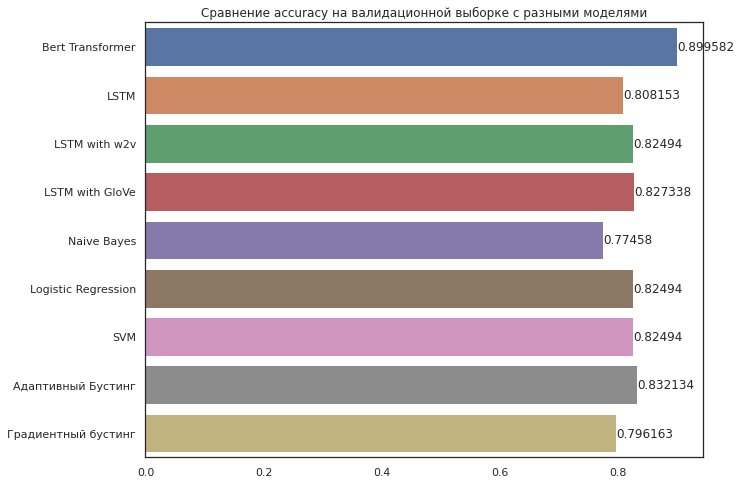

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.barplot(y = arr_title, x = arr_acc_val, orient='h')
for container in ax.containers:
    ax.bar_label(container)
ax.set_title('Сравнение accuracy на валидационной выборке с разными моделями')

Самое главное - сравнение точности на валидационной выборке. В данном случае самый лучший показатель у модели Bert (0.9), наименьший - у модели Naive Bayes. В целом, все значения больше 0.75. Также значения логистической регрессии, SVM и LSTM с word2vec одинаковы

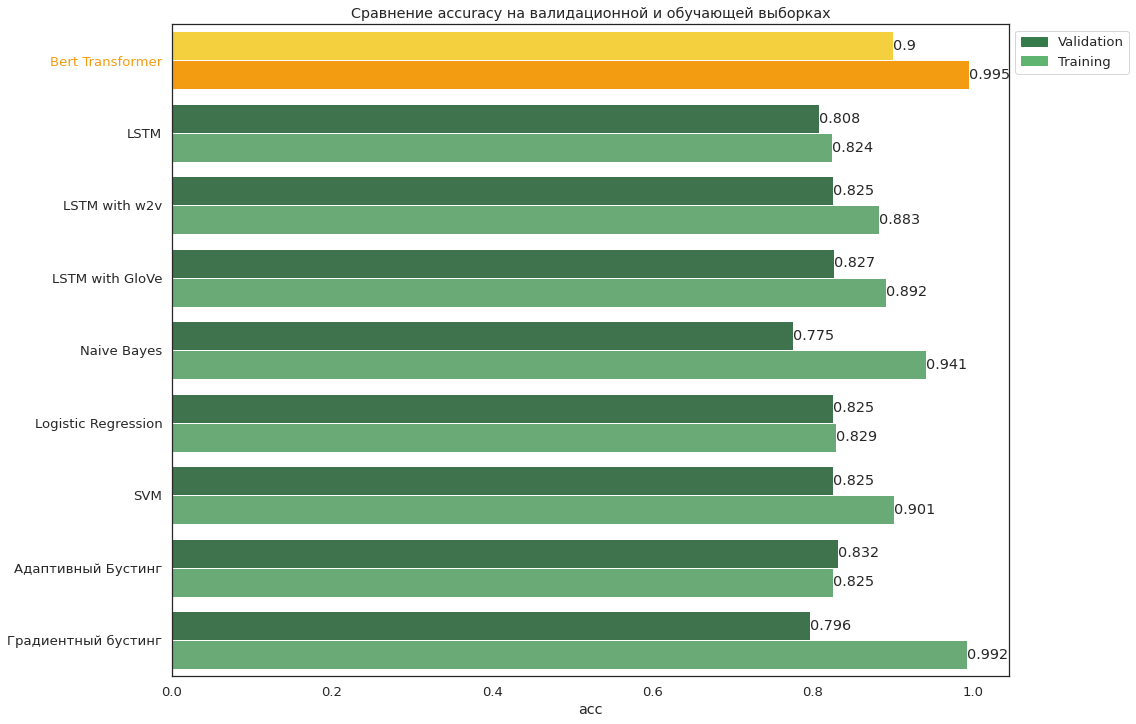

In [ ]:
sns.set(style="white", font_scale = 1.2)
fig, ax = plt.subplots(figsize=(15, 12))
pal = sns.color_palette("Greens_d", 2)
rank = np.array(range(2)).argsort().argsort()
ax = sns.barplot(x = 'acc',
                 y =  ['Bert Transformer', 'LSTM', 'LSTM with w2v','LSTM with GloVe',
                       'Naive Bayes', 'Logistic Regression','SVM', 'Адаптивный Бустинг',
                       'Градиентный бустинг', 'Bert Transformer', 'LSTM', 'LSTM with w2v',
                       'LSTM with GloVe', 'Naive Bayes', 'Logistic Regression','SVM',
                       'Адаптивный Бустинг', 'Градиентный бустинг'],
                 hue = 'var',
                 data = df_acc_all,
                 orient='h',
                 palette=np.array(pal[::-1])[rank])
for container in ax.containers:
    ax.bar_label(container)
ax.set_title('Сравнение accuracy на валидационной и обучающей выборках')
#выделение лучшего значения
ax.patches[0].set_facecolor('#F4D03F')
ax.patches[9].set_facecolor('#F39C12')
for i, tick_label in enumerate(ax.axes.get_yticklabels()):
    if tick_label.get_text()=="Bert Transformer":
        tick_label.set_color("#F39C12")
#отрисовка легенда
hands, labs = ax.get_legend_handles_labels()
plt.legend(handles=hands, title='', loc='upper left', labels=['Validation', 'Training'])
#обновление значений цветов легенды
leg = ax.get_legend()
leg.legendHandles[0].set_color(pal[1])
leg.legendHandles[1].set_color(pal[0])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.savefig('saved.png')

Bert на тревочной выборке показывает результат равный 0.99, что могло бы говорить о переобучении, однако на валидационной выборке результат также хороший - 0.9. Явное переобучение, как уже было сказано раньше - у моделей Naive Bayes и модели градиентного бустинга

Text(0.5, 1.0, 'Сравнение времени обучения разных моделей (в секундах)')

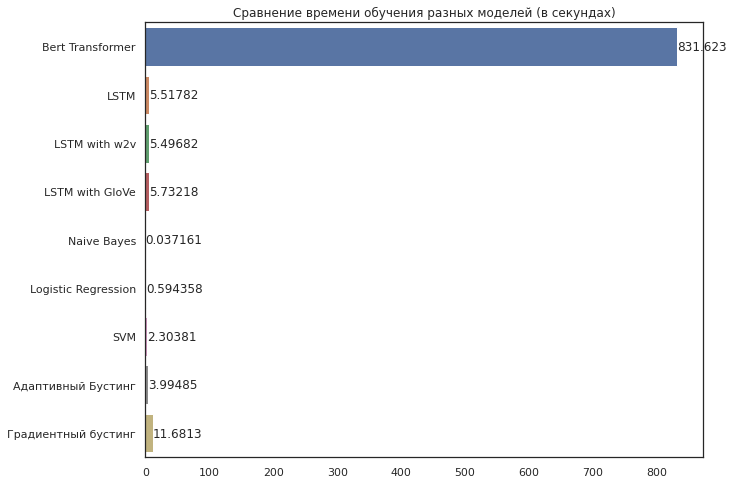

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.barplot(y = arr_title, x = arr_time, orient='h')
for container in ax.containers:
    ax.bar_label(container)
ax.set_title('Сравнение времени обучения разных моделей (в секундах)')

На графике видно, что время, потраченное на обучение Bert-трансформера, намного больше всего остального. Однако благодаря этому у данной модели самый высокий результат на валидационной выборке. Поэтому была выбрана данная модель, которая хорошо определяет тональность

# **Подстановка смайликов**

In [ ]:
#метод для предсказания категории
def predict(text):
    #также предобработка входного текста
    text_encod = re.sub(r"@[\w'._+-]+", '', text, flags=re.IGNORECASE)
    text_encod = re.sub(r"#[\w'._+-]+", '', text_encod, flags=re.IGNORECASE)
    text_encod = re.sub(r"https?://[^,\s]+,?", '', text_encod, flags=re.IGNORECASE)
    text_encod = text_encod.replace('[^\w\s]','')
    text_encod = re.sub(r'[^\w\s]+|[\d]+', '', text_encod, flags=re.IGNORECASE)
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    text_encod = re.sub(RE_WSPACE, ' ', text_encod)

    #токенизация текста
    encoding = tokenizer.encode_plus(
        text_encod,
        add_special_tokens=True,
        return_token_type_ids=False,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
    )

    out = {
          'text': text,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten()
      }

    input_ids = out["input_ids"].to(device)
    attention_mask = out["attention_mask"].to(device)

    #предсказание для всех категорий
    outputs = model(
        input_ids=input_ids.unsqueeze(0),
        attention_mask=attention_mask.unsqueeze(0)
    )

    #выбор категории по наибольшему значению
    prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]

    return [[prediction, text]]

In [ ]:
#метод для вывода смайлика
def get_emodji(preds):
    #предсказание категории твита
    # preds = predict(text)
    #словарь для получения значения каждой категории
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    for num, i in enumerate(preds):
      if label_dict_inverse[i] == 'not-relevant':
        arr = ['not-relevant class doesnt have emodji']
      else:
        #выбор случайного смайлика заданной категории
        arr = df['emodji'].where(label_dict_inverse[i]== df['categories']).dropna().reset_index(drop=True)
        print(num)
      print(f'Tweet: {df3.Text[num]}')
      print(f'Class: {label_dict_inverse[i]}')
      print(f'Emodji: {random.choice(arr)}')
      print(80*'-')

In [ ]:
get_emodji(predict_bert)

Выходные данные были обрезаны до нескольких последних строк (5000).
--------------------------------------------------------------------------------
276
Tweet: @britishmuseum @GenXMedia looks like a greave, but designed to be stitched directly onto substrate of leather or padding.
Class: surprise
Emodji: 😗
--------------------------------------------------------------------------------
277
Tweet: MT @NationalGallery The monumental 'Italian Woman' by Corot, best known as a landscape painter http://t.co/rIEtTypLYF http://t.co/cCHLqahyZH
Class: happy
Emodji: 😆
--------------------------------------------------------------------------------
278
Tweet: @neilcford @metoffice I am indeed keeping a safe distance today.  Other Informatics Lab colleagues are at @RAMMuseum today. cc @LabbyTheRat
Class: happy
Emodji: 😄
--------------------------------------------------------------------------------
279
Tweet: @NationalGallery I do. I use this in my history class for Renaissance art
Class: happy
Em

In [ ]:
get_emodji('@NationalGallery @ThePoldarkian I have always loved this painting.')

Tweet: @NationalGallery @ThePoldarkian I have always loved this painting.
Class: happy
Emodji: 🤣
--------------------------------------------------------------------------------


In [ ]:
get_emodji('Had an excellent lunchtime visit to @britishmuseum with @theresecoen this afternoon for the #DefiningBeauty exhibition.')

Tweet: Had an excellent lunchtime visit to @britishmuseum with @theresecoen this afternoon for the #DefiningBeauty exhibition.
Class: happy
Emodji: 😅
--------------------------------------------------------------------------------


In [ ]:
get_emodji('@Ophiolatrist @britishmuseum The stupid #French prick was crushed by my Russian Imperial ancestors. 😂 #Waterloo200')

Tweet: @Ophiolatrist @britishmuseum The stupid #French prick was crushed by my Russian Imperial ancestors. 😂 #Waterloo200
Class: angry
Emodji: 👿
--------------------------------------------------------------------------------


In [ ]:
get_emodji('From 12pm on @BBCCambs we preview #CastleHillOpen Day in #Cambridge with @TheCCT @CambsCC @kettlesyard http://t.co/pw5S1RUUcR')

Tweet: From 12pm on @BBCCambs we preview #CastleHillOpen Day in #Cambridge with @TheCCT @CambsCC @kettlesyard http://t.co/pw5S1RUUcR
Class: not-relevant
Emodji: not-relevant class doesnt have emodji
--------------------------------------------------------------------------------
